In [1]:
import os

from pathlib import Path, PurePath

In [2]:
import matplotlib.pyplot as plt

from skimage import color, io
from skimage.transform import rescale, resize, downscale_local_mean

In [3]:
raw_data_dir = Path(r'../data/raw')
craftsman_dir = raw_data_dir / 'Craftsman House'
victorian_dir = raw_data_dir / 'Victorian House'

processed_data_dir = Path(r'../data/processed')
craftsman_output_dir = processed_data_dir / 'Craftsman House'
victorian_output_dir = processed_data_dir / 'Victorian House'

Text(0.5,1,'New image')

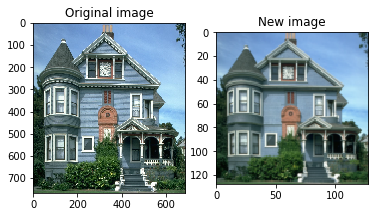

In [4]:
image = io.imread(victorian_dir / os.listdir(victorian_dir)[0])
image_resized = resize(image, (128, 128))

fig, axes = plt.subplots(nrows=1, ncols=2)

ax = axes.ravel()
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original image")

ax[1].imshow(image_resized, cmap='gray')
ax[1].set_title("New image")

In [5]:
Path

pathlib.Path

In [7]:
def resize_directory(directory, output_directory, size, display_step=100):
    """Resizes an entire directory of images. 

    Args:
        directory (`pathlib.Path`): A directory to preprocess.  Should
            contain images.
        size (`list`): The size of the target size.
        display_stp (:obj:`int`, optional): How many images to process before 
            displaying an image.  

    Raises:
        ValueError: If `size` is the wrong shape (not 1x2).
        ValueError: If `output_directory` is not a pathlib.Path object.
    """
    
    if len(size) != 2:
        raise ValueError('`size` should be of length 2.  '
                         'Found: {0}'.format(len(size)))
    if not isinstance(output_directory, PurePath):
        raise ValueError('output_directory should be a pathlib.Path object.'
                        'Found: {0}'.format(type(output_directory)))
    
    output_directory.mkdir(parents=True, exist_ok=True)
    
    i = 0
    existing_files = os.listdir(output_directory)
    for image_name in os.listdir(directory):
        image_out_name = image_name + str(size[0]) + 'x' + str(size[1]) + '.jpg'
        
        if image_out_name in existing_files:
            print(f'Skipped: {image_name} because it is already in {output_directory}')
        
        image = io.imread(directory / image_name)
        image_resized = resize(image, (size[0], size[1]))
        io.imsave(output_directory / image_out_name, image_resized)        
        print(f'Step: {i}.  Resized: {image_name}.  '
              f'Old size: {image.shape[0]}x{image.shape[1]}.  '
              f'New size: {image_resized.shape[0]}x{image_resized.shape[1]}.')

        if i%display_step == 0:
            fig, axes = plt.subplots(nrows=1, ncols=2)

            ax = axes.ravel()
            ax[0].imshow(image, cmap='gray')
            ax[0].set_title("Original image")

            ax[1].imshow(image_resized, cmap='gray')
            ax[1].set_title("New image")
        i += 1

Skipped: 1.Cali03.jpg because it is already in ..\data\processed\Victorian House
Step: 0.  Resized: 1.Cali03.jpg.  Old size: 767x687.  New size: 128x128.
Skipped: 10.stpaulmn02.jpg because it is already in ..\data\processed\Victorian House


Step: 1.  Resized: 10.stpaulmn02.jpg.  Old size: 800x793.  New size: 128x128.
Skipped: 100.31962.jpg because it is already in ..\data\processed\Victorian House
Step: 2.  Resized: 100.31962.jpg.  Old size: 401x600.  New size: 128x128.
Skipped: 101.800px-Diamond_District_House.jpg because it is already in ..\data\processed\Victorian House
Step: 3.  Resized: 101.800px-Diamond_District_House.jpg.  Old size: 565x800.  New size: 128x128.
Skipped: 102.Virginia.jpg because it is already in ..\data\processed\Victorian House


Step: 4.  Resized: 102.Virginia.jpg.  Old size: 1200x1800.  New size: 128x128.
Skipped: 103.10-victorian-house.jpg because it is already in ..\data\processed\Victorian House
Step: 5.  Resized: 103.10-victorian-house.jpg.  Old size: 500x427.  New size: 128x128.
Skipped: 104.tumblr_m7hvb6hksv1ql8cp2o1_1280.jpg because it is already in ..\data\processed\Victorian House


Step: 6.  Resized: 104.tumblr_m7hvb6hksv1ql8cp2o1_1280.jpg.  Old size: 890x1280.  New size: 128x128.
Skipped: 105.6908am_photo1-_1524859565.jpg because it is already in ..\data\processed\Victorian House


Step: 7.  Resized: 105.6908am_photo1-_1524859565.jpg.  Old size: 799x1200.  New size: 128x128.
Skipped: 106.114-years-old-victorian-house-13.jpg because it is already in ..\data\processed\Victorian House
Step: 8.  Resized: 106.114-years-old-victorian-house-13.jpg.  Old size: 500x701.  New size: 128x128.
Skipped: 107.1200px-Charles_and_Anna_Drain_House_%28Drain%2C_Oregon%29_-_cropped.jpg because it is already in ..\data\processed\Victorian House


Step: 9.  Resized: 107.1200px-Charles_and_Anna_Drain_House_%28Drain%2C_Oregon%29_-_cropped.jpg.  Old size: 1065x1200.  New size: 128x128.
Skipped: 108.Victorian_Historical_House.jpg because it is already in ..\data\processed\Victorian House


Step: 10.  Resized: 108.Victorian_Historical_House.jpg.  Old size: 1224x1632.  New size: 128x128.
Skipped: 109.victorian-style-1647594_960_720.jpg because it is already in ..\data\processed\Victorian House
Step: 11.  Resized: 109.victorian-style-1647594_960_720.jpg.  Old size: 638x960.  New size: 128x128.
Skipped: 11.Cali01.jpg because it is already in ..\data\processed\Victorian House


Step: 12.  Resized: 11.Cali01.jpg.  Old size: 767x671.  New size: 128x128.
Skipped: 110.Fabulous-Details-on-Victorian-House-Styles-Architecture-Exterior-with-Glass-Windows-and-Cozy-Facade.jpg because it is already in ..\data\processed\Victorian House


Step: 13.  Resized: 110.Fabulous-Details-on-Victorian-House-Styles-Architecture-Exterior-with-Glass-Windows-and-Cozy-Facade.jpg.  Old size: 990x904.  New size: 128x128.
Skipped: 111.victorian-houses.jpg because it is already in ..\data\processed\Victorian House
Step: 14.  Resized: 111.victorian-houses.jpg.  Old size: 450x650.  New size: 128x128.
Skipped: 112.victorian-1269908_960_720.jpg because it is already in ..\data\processed\Victorian House


Step: 15.  Resized: 112.victorian-1269908_960_720.jpg.  Old size: 720x960.  New size: 128x128.
Skipped: 113.2229Ard.jpg because it is already in ..\data\processed\Victorian House
Step: 16.  Resized: 113.2229Ard.jpg.  Old size: 332x600.  New size: 128x128.
Skipped: 114.Print_09.1507673965.jpg because it is already in ..\data\processed\Victorian House


Step: 17.  Resized: 114.Print_09.1507673965.jpg.  Old size: 900x1200.  New size: 128x128.
Skipped: 115.CDraaC9.jpg because it is already in ..\data\processed\Victorian House


Step: 18.  Resized: 115.CDraaC9.jpg.  Old size: 1976x1982.  New size: 128x128.
Skipped: 116.95560-B600.jpg because it is already in ..\data\processed\Victorian House
Step: 19.  Resized: 116.95560-B600.jpg.  Old size: 388x600.  New size: 128x128.
Skipped: 117.Gingerbread-style-Victorian-era-home-sept14.jpg because it is already in ..\data\processed\Victorian House


Step: 20.  Resized: 117.Gingerbread-style-Victorian-era-home-sept14.jpg.  Old size: 836x1255.  New size: 128x128.
Skipped: 118.1460392652180.jpeg because it is already in ..\data\processed\Victorian House
Step: 21.  Resized: 118.1460392652180.jpeg.  Old size: 411x616.  New size: 128x128.
Skipped: 119.victorian-house-oak-bluffs.jpg because it is already in ..\data\processed\Victorian House
Step: 22.  Resized: 119.victorian-house-oak-bluffs.jpg.  Old size: 470x600.  New size: 128x128.
Skipped: 12.NewY09.jpg because it is already in ..\data\processed\Victorian House


Step: 23.  Resized: 12.NewY09.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 120.Conn03.jpg because it is already in ..\data\processed\Victorian House


Step: 24.  Resized: 120.Conn03.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 121.1368292.jpg because it is already in ..\data\processed\Victorian House


Step: 25.  Resized: 121.1368292.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 122.victorian-exterior.jpg because it is already in ..\data\processed\Victorian House
Step: 26.  Resized: 122.victorian-exterior.jpg.  Old size: 640x514.  New size: 128x128.
Skipped: 123.Queen-Anne-Style-Home.jpg because it is already in ..\data\processed\Victorian House
Step: 27.  Resized: 123.Queen-Anne-Style-Home.jpg.  Old size: 752x500.  New size: 128x128.
Skipped: 124.il_fullxfull.369750399_iayd.jpg because it is already in ..\data\processed\Victorian House


Step: 28.  Resized: 124.il_fullxfull.369750399_iayd.jpg.  Old size: 1000x1500.  New size: 128x128.
Skipped: 125.shutterstock_291106406.jpg because it is already in ..\data\processed\Victorian House
Step: 29.  Resized: 125.shutterstock_291106406.jpg.  Old size: 750x1000.  New size: 128x128.
Skipped: 126.27041881161_01b9534204_o.jpg because it is already in ..\data\processed\Victorian House


Step: 30.  Resized: 126.27041881161_01b9534204_o.jpg.  Old size: 1024x1280.  New size: 128x128.
Skipped: 127.weatherford-victorian-salute-cropped.jpg because it is already in ..\data\processed\Victorian House


Step: 31.  Resized: 127.weatherford-victorian-salute-cropped.jpg.  Old size: 2475x3300.  New size: 128x128.
Skipped: 128.20150755bbaebb01ade.jpg because it is already in ..\data\processed\Victorian House
Step: 32.  Resized: 128.20150755bbaebb01ade.jpg.  Old size: 600x800.  New size: 128x128.
Skipped: 129.1449795583-wenonah.jpg because it is already in ..\data\processed\Victorian House


Step: 33.  Resized: 129.1449795583-wenonah.jpg.  Old size: 2000x2500.  New size: 128x128.
Skipped: 13.victorian-house-patricia-stalter.jpg because it is already in ..\data\processed\Victorian House
Step: 34.  Resized: 13.victorian-house-patricia-stalter.jpg.  Old size: 700x476.  New size: 128x128.
Skipped: 130.920x920.jpg because it is already in ..\data\processed\Victorian House


Step: 35.  Resized: 130.920x920.jpg.  Old size: 536x920.  New size: 128x128.
Skipped: 131.img_0977.jpg because it is already in ..\data\processed\Victorian House


Step: 36.  Resized: 131.img_0977.jpg.  Old size: 3000x4000.  New size: 128x128.
Skipped: 132.second-empire.jpg because it is already in ..\data\processed\Victorian House


Step: 37.  Resized: 132.second-empire.jpg.  Old size: 960x1280.  New size: 128x128.
Skipped: 133.queen-anne-brick-north-carolina.jpg because it is already in ..\data\processed\Victorian House
Step: 38.  Resized: 133.queen-anne-brick-north-carolina.jpg.  Old size: 442x600.  New size: 128x128.
Skipped: 134.e7MOqyC9YOtLT_Hajk4GfHxOTsHRQZQJth_dhtsAo0s.jpg because it is already in ..\data\processed\Victorian House


Step: 39.  Resized: 134.e7MOqyC9YOtLT_Hajk4GfHxOTsHRQZQJth_dhtsAo0s.jpg.  Old size: 682x1024.  New size: 128x128.
Skipped: 135.victorian-95374d-1024x671.jpg because it is already in ..\data\processed\Victorian House
Step: 40.  Resized: 135.victorian-95374d-1024x671.jpg.  Old size: 671x1024.  New size: 128x128.
Skipped: 136.Circa-Porch-Victorian-Homes.jpg because it is already in ..\data\processed\Victorian House


Step: 41.  Resized: 136.Circa-Porch-Victorian-Homes.jpg.  Old size: 533x800.  New size: 128x128.
Skipped: 137.Virg02.jpg because it is already in ..\data\processed\Victorian House


Step: 42.  Resized: 137.Virg02.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 138.chelsea-house-victorian.jpg because it is already in ..\data\processed\Victorian House
Step: 43.  Resized: 138.chelsea-house-victorian.jpg.  Old size: 412x550.  New size: 128x128.
Skipped: 139.-gracious-victorian-house-in-montreal-carl-purcell.jpg because it is already in ..\data\processed\Victorian House
Step: 44.  Resized: 139.-gracious-victorian-house-in-montreal-carl-purcell.jpg.  Old size: 609x900.  New size: 128x128.
Skipped: 14.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 45.  Resized: 14.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 140.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 46.  Resized: 140.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 141.tumblr_o8i74k1UyQ1uk274do1_500.jpg because it is already in ..\data\processed\Victorian House
Step: 47.  Resized: 141.tumblr_o8i74k1UyQ1uk274do1_500.jpg.  Old size: 625x500.  New size: 128x128.
Skipped: 142.victorian-house-designs.jpeg because it is already in ..\data\processed\Victorian House
Step: 48.  Resized: 142.victorian-house-designs.jpeg.  Old size: 375x500.  New size: 128x128.
Skipped: 143.picture-1-of-spellman-victorian.jpg because it is already in ..\data\processed\Victorian House
Step: 49.  Resized: 143.picture-1-of-spellman-victorian.jpg.  Old size: 408x596.  New size: 128x128.
Skipped: 144.bigstock-historic-house-260091_900.jpg because it is already in ..\data\processed\Victorian House


Step: 50.  Resized: 144.bigstock-historic-house-260091_900.jpg.  Old size: 624x900.  New size: 128x128.
Skipped: 145.Queen-Anne.jpg because it is already in ..\data\processed\Victorian House


Step: 51.  Resized: 145.Queen-Anne.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 146.23167jd_e_1479211232.jpg because it is already in ..\data\processed\Victorian House
Step: 52.  Resized: 146.23167jd_e_1479211232.jpg.  Old size: 640x960.  New size: 128x128.
Skipped: 147.hqdefault.jpg because it is already in ..\data\processed\Victorian House
Step: 53.  Resized: 147.hqdefault.jpg.  Old size: 360x480.  New size: 128x128.
Skipped: 148.tumblr_m2ia2kCFsw1ql8cp2o1_1280.jpg because it is already in ..\data\processed\Victorian House


Step: 54.  Resized: 148.tumblr_m2ia2kCFsw1ql8cp2o1_1280.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 149.Small_Victorian_House.jpg because it is already in ..\data\processed\Victorian House


Step: 55.  Resized: 149.Small_Victorian_House.jpg.  Old size: 900x1200.  New size: 128x128.
Skipped: 15.Cali07.jpg because it is already in ..\data\processed\Victorian House
Step: 56.  Resized: 15.Cali07.jpg.  Old size: 767x703.  New size: 128x128.
Skipped: 150.tumblr_n18z91IUrO1qg81ywo1_500.jpg because it is already in ..\data\processed\Victorian House


Step: 57.  Resized: 150.tumblr_n18z91IUrO1qg81ywo1_500.jpg.  Old size: 750x500.  New size: 128x128.
Skipped: 151.3606073559_e22ea39723.jpg because it is already in ..\data\processed\Victorian House
Step: 58.  Resized: 151.3606073559_e22ea39723.jpg.  Old size: 500x413.  New size: 128x128.
Skipped: 152.7d15bfbf-ae44-4558-83c2-2a5f2019ff0d.c10.jpg because it is already in ..\data\processed\Victorian House


Step: 59.  Resized: 152.7d15bfbf-ae44-4558-83c2-2a5f2019ff0d.c10.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 153.large.jpg because it is already in ..\data\processed\Victorian House


Step: 60.  Resized: 153.large.jpg.  Old size: 1200x1600.  New size: 128x128.
Skipped: 154.101985310.jpg because it is already in ..\data\processed\Victorian House
Step: 61.  Resized: 154.101985310.jpg.  Old size: 550x550.  New size: 128x128.
Skipped: 155.victorian2.jpg because it is already in ..\data\processed\Victorian House


Step: 62.  Resized: 155.victorian2.jpg.  Old size: 913x1530.  New size: 128x128.
Skipped: 156.eUnwKRgpE71x.jpg because it is already in ..\data\processed\Victorian House


Step: 63.  Resized: 156.eUnwKRgpE71x.jpg.  Old size: 1200x800.  New size: 128x128.
Skipped: 157.Victorian+Gothic+House.jpg because it is already in ..\data\processed\Victorian House
Step: 64.  Resized: 157.Victorian+Gothic+House.jpg.  Old size: 640x424.  New size: 128x128.
Skipped: 158.monti1894folkvic.jpg because it is already in ..\data\processed\Victorian House


Step: 65.  Resized: 158.monti1894folkvic.jpg.  Old size: 2591x3893.  New size: 128x128.
Skipped: 159.1200px-Aaron_Ferrey_House.jpg because it is already in ..\data\processed\Victorian House


Step: 66.  Resized: 159.1200px-Aaron_Ferrey_House.jpg.  Old size: 900x1200.  New size: 128x128.
Skipped: 16.ferndale-2010-037.jpg because it is already in ..\data\processed\Victorian House


Step: 67.  Resized: 16.ferndale-2010-037.jpg.  Old size: 4000x3000.  New size: 128x128.
Skipped: 160.small-victorian-house-plans-white-walls-gable-roof-tower-stone-steps-lantern-lamps-windows-door-victorian-design.jpg because it is already in ..\data\processed\Victorian House
Step: 68.  Resized: 160.small-victorian-house-plans-white-walls-gable-roof-tower-stone-steps-lantern-lamps-windows-door-victorian-design.jpg.  Old size: 990x762.  New size: 128x128.
Skipped: 161.shingle-patterns-hale-house.jpg because it is already in ..\data\processed\Victorian House


Step: 69.  Resized: 161.shingle-patterns-hale-house.jpg.  Old size: 1200x1065.  New size: 128x128.
Skipped: 162.Victorian+2.jpg because it is already in ..\data\processed\Victorian House
Step: 70.  Resized: 162.Victorian+2.jpg.  Old size: 671x900.  New size: 128x128.
Skipped: 163.il_fullxfull.240923255.jpg because it is already in ..\data\processed\Victorian House


Step: 71.  Resized: 163.il_fullxfull.240923255.jpg.  Old size: 1411x998.  New size: 128x128.
Skipped: 164.wpid-Photo-Oct-18-2013-1152-PM.jpg because it is already in ..\data\processed\Victorian House
Step: 72.  Resized: 164.wpid-Photo-Oct-18-2013-1152-PM.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 165.HeimHouse_LAC2.jpg because it is already in ..\data\processed\Victorian House


Step: 73.  Resized: 165.HeimHouse_LAC2.jpg.  Old size: 620x490.  New size: 128x128.
Skipped: 166.1447-McAllister-58b11fd75f9b5860466bf797-cf1412dc8bb44aa38f0a09b64fabe2f6.jpg because it is already in ..\data\processed\Victorian House
Step: 74.  Resized: 166.1447-McAllister-58b11fd75f9b5860466bf797-cf1412dc8bb44aa38f0a09b64fabe2f6.jpg.  Old size: 640x960.  New size: 128x128.
Skipped: 167.Beautiful-Victorian-homes-with-black-metal-railing-staircase-small-garden-in-front-yard-and-small-bay-window.jpg because it is already in ..\data\processed\Victorian House


Step: 75.  Resized: 167.Beautiful-Victorian-homes-with-black-metal-railing-staircase-small-garden-in-front-yard-and-small-bay-window.jpg.  Old size: 734x550.  New size: 128x128.
Skipped: 168.Heritage-Hill-Victorian-Mansion.jpg because it is already in ..\data\processed\Victorian House
Step: 76.  Resized: 168.Heritage-Hill-Victorian-Mansion.jpg.  Old size: 427x640.  New size: 128x128.
Skipped: 169.bricked-white-pillar-victorian-mansion-090618-2.jpg because it is already in ..\data\processed\Victorian House


Step: 77.  Resized: 169.bricked-white-pillar-victorian-mansion-090618-2.jpg.  Old size: 844x1000.  New size: 128x128.
Skipped: 17.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 78.  Resized: 17.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 170.victorian-9.jpg because it is already in ..\data\processed\Victorian House
Step: 79.  Resized: 170.victorian-9.jpg.  Old size: 414x623.  New size: 128x128.
Skipped: 171.victorian-terraced-villa-after.jpg because it is already in ..\data\processed\Victorian House
Step: 80.  Resized: 171.victorian-terraced-villa-after.jpg.  Old size: 460x614.  New size: 128x128.
Skipped: 172.s-l1000.jpg because it is already in ..\data\processed\Victorian House


Step: 81.  Resized: 172.s-l1000.jpg.  Old size: 777x1000.  New size: 128x128.
Skipped: 173.64.jpg because it is already in ..\data\processed\Victorian House
Step: 82.  Resized: 173.64.jpg.  Old size: 640x480.  New size: 128x128.
Skipped: 174.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 83.  Resized: 174.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 175.P4240131-lo-res-728x644.jpg because it is already in ..\data\processed\Victorian House
Step: 84.  Resized: 175.P4240131-lo-res-728x644.jpg.  Old size: 644x728.  New size: 128x128.
Skipped: 176.920x920.jpg because it is already in ..\data\processed\Victorian House


Step: 85.  Resized: 176.920x920.jpg.  Old size: 612x920.  New size: 128x128.
Skipped: 177.1447-McAllister-58b11fd75f9b5860466bf797-cf1412dc8bb44aa38f0a09b64fabe2f6.jpg because it is already in ..\data\processed\Victorian House
Step: 86.  Resized: 177.1447-McAllister-58b11fd75f9b5860466bf797-cf1412dc8bb44aa38f0a09b64fabe2f6.jpg.  Old size: 640x960.  New size: 128x128.
Skipped: 178.JN2By.jpg because it is already in ..\data\processed\Victorian House


Step: 87.  Resized: 178.JN2By.jpg.  Old size: 2057x2867.  New size: 128x128.
Skipped: 179.1363.jpg because it is already in ..\data\processed\Victorian House
Step: 88.  Resized: 179.1363.jpg.  Old size: 459x612.  New size: 128x128.
Skipped: 18.B9317453955Z.1_20150522165344_000_G5QASBJPH.1-0.jpg because it is already in ..\data\processed\Victorian House
Step: 89.  Resized: 18.B9317453955Z.1_20150522165344_000_G5QASBJPH.1-0.jpg.  Old size: 712x534.  New size: 128x128.
Skipped: 180.queenanne-2.jpg because it is already in ..\data\processed\Victorian House


Step: 90.  Resized: 180.queenanne-2.jpg.  Old size: 788x983.  New size: 128x128.
Skipped: 181.Buy_vs_Rent_Victorian_Style_House.jpg because it is already in ..\data\processed\Victorian House
Step: 91.  Resized: 181.Buy_vs_Rent_Victorian_Style_House.jpg.  Old size: 375x500.  New size: 128x128.
Skipped: 182.Small-Victorian-house-in-white-and-purple.jpg because it is already in ..\data\processed\Victorian House
Step: 92.  Resized: 182.Small-Victorian-house-in-white-and-purple.jpg.  Old size: 667x500.  New size: 128x128.
Skipped: 183.victorian.jpg because it is already in ..\data\processed\Victorian House


Step: 93.  Resized: 183.victorian.jpg.  Old size: 600x450.  New size: 128x128.
Skipped: 184.port-townsend-house-1981.jpg because it is already in ..\data\processed\Victorian House


Step: 94.  Resized: 184.port-townsend-house-1981.jpg.  Old size: 3094x2656.  New size: 128x128.
Skipped: 185.Victorian_house,_Naarden,_Holland.jpg because it is already in ..\data\processed\Victorian House


Step: 95.  Resized: 185.Victorian_house,_Naarden,_Holland.jpg.  Old size: 850x1280.  New size: 128x128.
Skipped: 186.01-exterior.jpg because it is already in ..\data\processed\Victorian House


Step: 96.  Resized: 186.01-exterior.jpg.  Old size: 695x1236.  New size: 128x128.
Skipped: 187.hale+house.jpg because it is already in ..\data\processed\Victorian House
Step: 97.  Resized: 187.hale+house.jpg.  Old size: 320x400.  New size: 128x128.
Skipped: 188.victorian-exterior.jpg because it is already in ..\data\processed\Victorian House
Step: 98.  Resized: 188.victorian-exterior.jpg.  Old size: 788x500.  New size: 128x128.
Skipped: 189.245e03b11a26cdd8ce2d758d0b3ca0e6.jpg because it is already in ..\data\processed\Victorian House


Step: 99.  Resized: 189.245e03b11a26cdd8ce2d758d0b3ca0e6.jpg.  Old size: 1024x826.  New size: 128x128.
Skipped: 19.Wooden_Queen_Anne_house_in_Fairfield,_Iowa.jpg because it is already in ..\data\processed\Victorian House


Step: 100.  Resized: 19.Wooden_Queen_Anne_house_in_Fairfield,_Iowa.jpg.  Old size: 988x1024.  New size: 128x128.
Skipped: 190.Victorian-House.jpg because it is already in ..\data\processed\Victorian House
Step: 101.  Resized: 190.Victorian-House.jpg.  Old size: 480x600.  New size: 128x128.
Skipped: 191.Victorian-Houses-21.jpg because it is already in ..\data\processed\Victorian House


Step: 102.  Resized: 191.Victorian-Houses-21.jpg.  Old size: 480x640.  New size: 128x128.
Skipped: 192.small-victorian-house-plans-granite-walls-gable-roofs-chimney-porch-column-windows-victorian-design.jpg because it is already in ..\data\processed\Victorian House
Step: 103.  Resized: 192.small-victorian-house-plans-granite-walls-gable-roofs-chimney-porch-column-windows-victorian-design.jpg.  Old size: 990x708.  New size: 128x128.
Skipped: 193.EVM-NW-Corner.jpg because it is already in ..\data\processed\Victorian House


Step: 104.  Resized: 193.EVM-NW-Corner.jpg.  Old size: 338x540.  New size: 128x128.
Skipped: 194.montclair-1508679295-6032.jpg because it is already in ..\data\processed\Victorian House


Step: 105.  Resized: 194.montclair-1508679295-6032.jpg.  Old size: 900x1200.  New size: 128x128.
Skipped: 195.romanesque-queen-anne-with-brick-tower-usa.jpg because it is already in ..\data\processed\Victorian House


Step: 106.  Resized: 195.romanesque-queen-anne-with-brick-tower-usa.jpg.  Old size: 1942x2020.  New size: 128x128.
Skipped: 196.victorianhouse-8.jpg because it is already in ..\data\processed\Victorian House
Step: 107.  Resized: 196.victorianhouse-8.jpg.  Old size: 450x700.  New size: 128x128.
Skipped: 197.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 108.  Resized: 197.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 198.Painted+Lady.jpg because it is already in ..\data\processed\Victorian House


Step: 109.  Resized: 198.Painted+Lady.jpg.  Old size: 1125x1500.  New size: 128x128.
Skipped: 199.207499-Old-Creepy-Victorian-House.jpg because it is already in ..\data\processed\Victorian House
Step: 110.  Resized: 199.207499-Old-Creepy-Victorian-House.jpg.  Old size: 600x428.  New size: 128x128.
Skipped: 2.Oreg07.jpg because it is already in ..\data\processed\Victorian House
Step: 111.  Resized: 2.Oreg07.jpg.  Old size: 630x738.  New size: 128x128.
Skipped: 20.victorian%5B1%5D.jpg because it is already in ..\data\processed\Victorian House


Step: 112.  Resized: 20.victorian%5B1%5D.jpg.  Old size: 578x770.  New size: 128x128.
Skipped: 200.6739894273_d77a03230e_b.jpg because it is already in ..\data\processed\Victorian House
Step: 113.  Resized: 200.6739894273_d77a03230e_b.jpg.  Old size: 733x698.  New size: 128x128.
Skipped: 201.house-with-turret00018.jpg because it is already in ..\data\processed\Victorian House


Step: 114.  Resized: 201.house-with-turret00018.jpg.  Old size: 838x1252.  New size: 128x128.
Skipped: 202.HeimHouse_LAC2.jpg because it is already in ..\data\processed\Victorian House
Step: 115.  Resized: 202.HeimHouse_LAC2.jpg.  Old size: 620x490.  New size: 128x128.
Skipped: 203.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 116.  Resized: 203.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 204.wpid-Photo-Oct-18-2013-1152-PM.jpg because it is already in ..\data\processed\Victorian House


Step: 117.  Resized: 204.wpid-Photo-Oct-18-2013-1152-PM.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 205.slide_355600_3902707_free.jpg because it is already in ..\data\processed\Victorian House
Step: 118.  Resized: 205.slide_355600_3902707_free.jpg.  Old size: 667x1000.  New size: 128x128.
Skipped: 206.533431-L.jpg because it is already in ..\data\processed\Victorian House


Step: 119.  Resized: 206.533431-L.jpg.  Old size: 1182x1600.  New size: 128x128.
Skipped: 207.800px-Trube_Castle,_Galveston.jpg because it is already in ..\data\processed\Victorian House
Step: 120.  Resized: 207.800px-Trube_Castle,_Galveston.jpg.  Old size: 598x800.  New size: 128x128.
Skipped: 208.Buy_vs_Rent_Victorian_Style_House.jpg because it is already in ..\data\processed\Victorian House
Step: 121.  Resized: 208.Buy_vs_Rent_Victorian_Style_House.jpg.  Old size: 375x500.  New size: 128x128.
Skipped: 209.EVM-NW-Corner.jpg because it is already in ..\data\processed\Victorian House


Step: 122.  Resized: 209.EVM-NW-Corner.jpg.  Old size: 338x540.  New size: 128x128.
Skipped: 21.20-victorian-house.jpg because it is already in ..\data\processed\Victorian House
Step: 123.  Resized: 21.20-victorian-house.jpg.  Old size: 354x500.  New size: 128x128.
Skipped: 210.queen-ann-victorian-1889-dover-foxcroft-maine.jpg because it is already in ..\data\processed\Victorian House
Step: 124.  Resized: 210.queen-ann-victorian-1889-dover-foxcroft-maine.jpg.  Old size: 619x924.  New size: 128x128.
Skipped: 211.8w9vXb.jpg because it is already in ..\data\processed\Victorian House


Step: 125.  Resized: 211.8w9vXb.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 212.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 126.  Resized: 212.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 213.Queen+Anne.jpg because it is already in ..\data\processed\Victorian House
Step: 127.  Resized: 213.Queen+Anne.jpg.  Old size: 526x718.  New size: 128x128.
Skipped: 214.montclair-1508679295-6032.jpg because it is already in ..\data\processed\Victorian House


Step: 128.  Resized: 214.montclair-1508679295-6032.jpg.  Old size: 900x1200.  New size: 128x128.
Skipped: 215.844e96bacdea6784ac6f26871058733d1.jpg because it is already in ..\data\processed\Victorian House
Step: 129.  Resized: 215.844e96bacdea6784ac6f26871058733d1.jpg.  Old size: 640x556.  New size: 128x128.
Skipped: 216.victorian-house-interior-they-design-intended-for-victorian-house-15-fabulous-victorian-house-interior.jpg because it is already in ..\data\processed\Victorian House


Step: 130.  Resized: 216.victorian-house-interior-they-design-intended-for-victorian-house-15-fabulous-victorian-house-interior.jpg.  Old size: 2048x1536.  New size: 128x128.
Skipped: 217.81117W_e_1479206533.jpg because it is already in ..\data\processed\Victorian House
Step: 131.  Resized: 217.81117W_e_1479206533.jpg.  Old size: 351x450.  New size: 128x128.
Skipped: 218.tumblr_me0vpzxKCZ1ql8cp2o1_1280.jpg because it is already in ..\data\processed\Victorian House
Step: 132.  Resized: 218.tumblr_me0vpzxKCZ1ql8cp2o1_1280.jpg.  Old size: 720x805.  New size: 128x128.
Skipped: 219.hale+house.jpg because it is already in ..\data\processed\Victorian House


Step: 133.  Resized: 219.hale+house.jpg.  Old size: 320x400.  New size: 128x128.
Skipped: 22.pink_lady.jpg because it is already in ..\data\processed\Victorian House
Step: 134.  Resized: 22.pink_lady.jpg.  Old size: 1000x745.  New size: 128x128.
Skipped: 220.old-home-5.jpg because it is already in ..\data\processed\Victorian House


Step: 135.  Resized: 220.old-home-5.jpg.  Old size: 635x638.  New size: 128x128.
Skipped: 221.691382.jpg because it is already in ..\data\processed\Victorian House


Step: 136.  Resized: 221.691382.jpg.  Old size: 1000x1500.  New size: 128x128.
Skipped: 222.1363.jpg because it is already in ..\data\processed\Victorian House
Step: 137.  Resized: 222.1363.jpg.  Old size: 459x612.  New size: 128x128.
Skipped: 223.victorian_house2.jpg because it is already in ..\data\processed\Victorian House


Step: 138.  Resized: 223.victorian_house2.jpg.  Old size: 1500x2000.  New size: 128x128.
Skipped: 224.very_classy_victorian_house_in_port_townsend_wa_img6634a.jpg because it is already in ..\data\processed\Victorian House


Step: 139.  Resized: 224.very_classy_victorian_house_in_port_townsend_wa_img6634a.jpg.  Old size: 804x1024.  New size: 128x128.
Skipped: 225.2-ext-05-GrandManor_gn.jpeg because it is already in ..\data\processed\Victorian House


Step: 140.  Resized: 225.2-ext-05-GrandManor_gn.jpeg.  Old size: 3578x3393.  New size: 128x128.
Skipped: 226.s-l1000.jpg because it is already in ..\data\processed\Victorian House


Step: 141.  Resized: 226.s-l1000.jpg.  Old size: 765x1000.  New size: 128x128.
Skipped: 227.6293250460_21a19cf829_b.jpg because it is already in ..\data\processed\Victorian House
Step: 142.  Resized: 227.6293250460_21a19cf829_b.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 228.Screenshot-270.jpg because it is already in ..\data\processed\Victorian House


Step: 143.  Resized: 228.Screenshot-270.jpg.  Old size: 768x1360.  New size: 128x128.
Skipped: 229.richardi-house.jpg because it is already in ..\data\processed\Victorian House


Step: 144.  Resized: 229.richardi-house.jpg.  Old size: 863x1280.  New size: 128x128.
Skipped: 23.Oreg09.jpg because it is already in ..\data\processed\Victorian House


Step: 145.  Resized: 23.Oreg09.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 230.Victorian-Houses-21.jpg because it is already in ..\data\processed\Victorian House
Step: 146.  Resized: 230.Victorian-Houses-21.jpg.  Old size: 480x640.  New size: 128x128.
Skipped: 231.JN2By.jpg because it is already in ..\data\processed\Victorian House


Step: 147.  Resized: 231.JN2By.jpg.  Old size: 2057x2867.  New size: 128x128.
Skipped: 232.32109934_08958b84da_z.jpg because it is already in ..\data\processed\Victorian House
Step: 148.  Resized: 232.32109934_08958b84da_z.jpg.  Old size: 480x640.  New size: 128x128.
Skipped: 233._MG_0702_4_5_6Balanced.0.jpg because it is already in ..\data\processed\Victorian House


Step: 149.  Resized: 233._MG_0702_4_5_6Balanced.0.jpg.  Old size: 800x1200.  New size: 128x128.
Skipped: 234.small-victorian-house-plans-steep-gable-roof-column-windows-double-doors-railing-patio-deck-victorian-design.jpg because it is already in ..\data\processed\Victorian House
Step: 150.  Resized: 234.small-victorian-house-plans-steep-gable-roof-column-windows-double-doors-railing-patio-deck-victorian-design.jpg.  Old size: 990x658.  New size: 128x128.
Skipped: 235.evanston09.jpg because it is already in ..\data\processed\Victorian House


Step: 151.  Resized: 235.evanston09.jpg.  Old size: 824x900.  New size: 128x128.
Skipped: 236.7231345808_b566a6bb45_b.jpg because it is already in ..\data\processed\Victorian House
Step: 152.  Resized: 236.7231345808_b566a6bb45_b.jpg.  Old size: 682x1024.  New size: 128x128.
Skipped: 237.queenanne-1080x675.jpg because it is already in ..\data\processed\Victorian House


Step: 153.  Resized: 237.queenanne-1080x675.jpg.  Old size: 675x1080.  New size: 128x128.
Skipped: 238.queen-ann-victorian-1889-dover-foxcroft-maine.jpg because it is already in ..\data\processed\Victorian House
Step: 154.  Resized: 238.queen-ann-victorian-1889-dover-foxcroft-maine.jpg.  Old size: 619x924.  New size: 128x128.
Skipped: 239.slide_355600_3902707_free.jpg because it is already in ..\data\processed\Victorian House


Step: 155.  Resized: 239.slide_355600_3902707_free.jpg.  Old size: 667x1000.  New size: 128x128.
Skipped: 24.Cali18.jpg because it is already in ..\data\processed\Victorian House


Step: 156.  Resized: 24.Cali18.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 240.533431-L.jpg because it is already in ..\data\processed\Victorian House


Step: 157.  Resized: 240.533431-L.jpg.  Old size: 1182x1600.  New size: 128x128.
Skipped: 241.800px-Trube_Castle,_Galveston.jpg because it is already in ..\data\processed\Victorian House
Step: 158.  Resized: 241.800px-Trube_Castle,_Galveston.jpg.  Old size: 598x800.  New size: 128x128.
Skipped: 242.81117W_e_1479206533.jpg because it is already in ..\data\processed\Victorian House
Step: 159.  Resized: 242.81117W_e_1479206533.jpg.  Old size: 351x450.  New size: 128x128.
Skipped: 243.victorian-house-interior-they-design-intended-for-victorian-house-15-fabulous-victorian-house-interior.jpg because it is already in ..\data\processed\Victorian House


Step: 160.  Resized: 243.victorian-house-interior-they-design-intended-for-victorian-house-15-fabulous-victorian-house-interior.jpg.  Old size: 2048x1536.  New size: 128x128.
Skipped: 244.tumblr_me0vpzxKCZ1ql8cp2o1_1280.jpg because it is already in ..\data\processed\Victorian House
Step: 161.  Resized: 244.tumblr_me0vpzxKCZ1ql8cp2o1_1280.jpg.  Old size: 720x805.  New size: 128x128.
Skipped: 245.Queen+Anne.jpg because it is already in ..\data\processed\Victorian House


Step: 162.  Resized: 245.Queen+Anne.jpg.  Old size: 526x718.  New size: 128x128.
Skipped: 246.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 163.  Resized: 246.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 247.2-ext-05-GrandManor_gn.jpeg because it is already in ..\data\processed\Victorian House


Step: 164.  Resized: 247.2-ext-05-GrandManor_gn.jpeg.  Old size: 3578x3393.  New size: 128x128.
Skipped: 248.8w9vXb.jpg because it is already in ..\data\processed\Victorian House


Step: 165.  Resized: 248.8w9vXb.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 249.2651361456_a14470cc93.jpg because it is already in ..\data\processed\Victorian House
Step: 166.  Resized: 249.2651361456_a14470cc93.jpg.  Old size: 500x365.  New size: 128x128.
Skipped: 25.Oreg06.jpg because it is already in ..\data\processed\Victorian House


Step: 167.  Resized: 25.Oreg06.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 250.s-l1000.jpg because it is already in ..\data\processed\Victorian House


Step: 168.  Resized: 250.s-l1000.jpg.  Old size: 765x1000.  New size: 128x128.
Skipped: 251.844e96bacdea6784ac6f26871058733d1.jpg because it is already in ..\data\processed\Victorian House
Step: 169.  Resized: 251.844e96bacdea6784ac6f26871058733d1.jpg.  Old size: 640x556.  New size: 128x128.
Skipped: 252.historic-victorian-home-thumb660948.jpg because it is already in ..\data\processed\Victorian House
Step: 170.  Resized: 252.historic-victorian-home-thumb660948.jpg.  Old size: 450x300.  New size: 128x128.
Skipped: 253.XL_100_0028a.jpg because it is already in ..\data\processed\Victorian House


Step: 171.  Resized: 253.XL_100_0028a.jpg.  Old size: 605x800.  New size: 128x128.
Skipped: 254.victorian-house.jpg because it is already in ..\data\processed\Victorian House
Step: 172.  Resized: 254.victorian-house.jpg.  Old size: 477x640.  New size: 128x128.
Skipped: 255.small-victorian-house-plans-green-walls-railing-stairs-stone-pavers-tall-windows-chimney-deck-victorian-design.jpg because it is already in ..\data\processed\Victorian House


Step: 173.  Resized: 255.small-victorian-house-plans-green-walls-railing-stairs-stone-pavers-tall-windows-chimney-deck-victorian-design.jpg.  Old size: 841x800.  New size: 128x128.
Skipped: 256.1200px-Victorian_villa%2C_Palmerston_Road_Edinburgh.jpg because it is already in ..\data\processed\Victorian House


Step: 174.  Resized: 256.1200px-Victorian_villa%2C_Palmerston_Road_Edinburgh.jpg.  Old size: 1600x1200.  New size: 128x128.
Skipped: 257.architect-greenwich-connecticut-ct-residential-new.jpg because it is already in ..\data\processed\Victorian House


Step: 175.  Resized: 257.architect-greenwich-connecticut-ct-residential-new.jpg.  Old size: 700x1200.  New size: 128x128.
Skipped: 258.fulton14.0.jpg because it is already in ..\data\processed\Victorian House


Step: 176.  Resized: 258.fulton14.0.jpg.  Old size: 900x1600.  New size: 128x128.
Skipped: 259.old-home-5.jpg because it is already in ..\data\processed\Victorian House
Step: 177.  Resized: 259.old-home-5.jpg.  Old size: 635x638.  New size: 128x128.
Skipped: 26.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 178.  Resized: 26.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 260.Victorian+Home+Woodwork+12.jpg because it is already in ..\data\processed\Victorian House
Step: 179.  Resized: 260.Victorian+Home+Woodwork+12.jpg.  Old size: 750x1000.  New size: 128x128.
Skipped: 261.424-630x473.jpg because it is already in ..\data\processed\Victorian House


Step: 180.  Resized: 261.424-630x473.jpg.  Old size: 473x630.  New size: 128x128.
Skipped: 262.Street-facade-of-the-Victorian-Noe-Valley-House-in-San-Francisco.jpg because it is already in ..\data\processed\Victorian House


Step: 181.  Resized: 262.Street-facade-of-the-Victorian-Noe-Valley-House-in-San-Francisco.jpg.  Old size: 1103x825.  New size: 128x128.
Skipped: 263.20160514_160709_HDR.jpg because it is already in ..\data\processed\Victorian House


Step: 182.  Resized: 263.20160514_160709_HDR.jpg.  Old size: 2160x3840.  New size: 128x128.
Skipped: 264.032D-0550-front-main-8.jpg because it is already in ..\data\processed\Victorian House
Step: 183.  Resized: 264.032D-0550-front-main-8.jpg.  Old size: 600x800.  New size: 128x128.
Skipped: 265.victorian_house_plan_topeka_42-012_front.jpg because it is already in ..\data\processed\Victorian House


Step: 184.  Resized: 265.victorian_house_plan_topeka_42-012_front.jpg.  Old size: 853x1280.  New size: 128x128.
Skipped: 266.Victorian_house_on_Mt_Vernon.jpg because it is already in ..\data\processed\Victorian House


Step: 185.  Resized: 266.Victorian_house_on_Mt_Vernon.jpg.  Old size: 1467x2688.  New size: 128x128.
Skipped: 267.dccbb00687949540486aba4ae5c75a7d--old-victorian-houses-victorian-house-colors.jpg because it is already in ..\data\processed\Victorian House
Step: 186.  Resized: 267.dccbb00687949540486aba4ae5c75a7d--old-victorian-houses-victorian-house-colors.jpg.  Old size: 599x640.  New size: 128x128.
Skipped: 268.Victorian_Terraced_Houses%2C_Yeovil_-_geograph.org.uk_-_660437.jpg because it is already in ..\data\processed\Victorian House
Step: 187.  Resized: 268.Victorian_Terraced_Houses%2C_Yeovil_-_geograph.org.uk_-_660437.jpg.  Old size: 480x640.  New size: 128x128.
Skipped: 269.3912528875_87a230e7f1_b.jpg because it is already in ..\data\processed\Victorian House


Step: 188.  Resized: 269.3912528875_87a230e7f1_b.jpg.  Old size: 1024x892.  New size: 128x128.
Skipped: 27.victorian-house-712230_640.jpg because it is already in ..\data\processed\Victorian House
Step: 189.  Resized: 27.victorian-house-712230_640.jpg.  Old size: 426x640.  New size: 128x128.
Skipped: 270.c3e16b626d8aa02a1e0031b01fd2f2e7.jpg because it is already in ..\data\processed\Victorian House
Step: 190.  Resized: 270.c3e16b626d8aa02a1e0031b01fd2f2e7.jpg.  Old size: 386x566.  New size: 128x128.
Skipped: 271.3859158211_ecfd1da500_b.jpg because it is already in ..\data\processed\Victorian House


Step: 191.  Resized: 271.3859158211_ecfd1da500_b.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 272.rawImage.jpg because it is already in ..\data\processed\Victorian House


Step: 192.  Resized: 272.rawImage.jpg.  Old size: 1365x2048.  New size: 128x128.
Skipped: 273.victorian_house_plan_canterbury_30-516_front_0.jpg because it is already in ..\data\processed\Victorian House


Step: 193.  Resized: 273.victorian_house_plan_canterbury_30-516_front_0.jpg.  Old size: 853x1280.  New size: 128x128.
Skipped: 274.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 194.  Resized: 274.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 275.Canfield-Block0153.jpg because it is already in ..\data\processed\Victorian House
Step: 195.  Resized: 275.Canfield-Block0153.jpg.  Old size: 600x400.  New size: 128x128.
Skipped: 276.Victorian-Flatbush-NYC-Untapped-Cities-Homes-1.jpg because it is already in ..\data\processed\Victorian House


Step: 196.  Resized: 276.Victorian-Flatbush-NYC-Untapped-Cities-Homes-1.jpg.  Old size: 800x1097.  New size: 128x128.
Skipped: 277.c3e16b626d8aa02a1e0031b01fd2f2e7.jpg because it is already in ..\data\processed\Victorian House
Step: 197.  Resized: 277.c3e16b626d8aa02a1e0031b01fd2f2e7.jpg.  Old size: 386x566.  New size: 128x128.
Skipped: 278.QQQQ01.jpg because it is already in ..\data\processed\Victorian House


Step: 198.  Resized: 278.QQQQ01.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 279.victorian.jpg because it is already in ..\data\processed\Victorian House
Step: 199.  Resized: 279.victorian.jpg.  Old size: 306x430.  New size: 128x128.
Skipped: 28.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 200.  Resized: 28.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 280.552d79a5a3ddd05d26e8fdb4dc9a633f.jpg because it is already in ..\data\processed\Victorian House
Step: 201.  Resized: 280.552d79a5a3ddd05d26e8fdb4dc9a633f.jpg.  Old size: 640x480.  New size: 128x128.
Skipped: 281.3912528875_87a230e7f1_b.jpg because it is already in ..\data\processed\Victorian House


Step: 202.  Resized: 281.3912528875_87a230e7f1_b.jpg.  Old size: 1024x892.  New size: 128x128.
Skipped: 282.DFE4EE3A-8D2F-45BB-9E3A2A9D782A5C83.jpg because it is already in ..\data\processed\Victorian House
Step: 203.  Resized: 282.DFE4EE3A-8D2F-45BB-9E3A2A9D782A5C83.jpg.  Old size: 426x600.  New size: 128x128.
Skipped: 283.1400948204863.jpeg because it is already in ..\data\processed\Victorian House


Step: 204.  Resized: 283.1400948204863.jpeg.  Old size: 1706x1279.  New size: 128x128.
Skipped: 284.Victorian-lake-house.jpg because it is already in ..\data\processed\Victorian House


Step: 205.  Resized: 284.Victorian-lake-house.jpg.  Old size: 1080x1440.  New size: 128x128.
Skipped: 285.1875-victorian-kentucky-before-painting.jpg because it is already in ..\data\processed\Victorian House


Step: 206.  Resized: 285.1875-victorian-kentucky-before-painting.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 286.3037796-inline-i-2-why-victorian-architecture-became-the-stereotypical-haunted-house.jpg because it is already in ..\data\processed\Victorian House
Step: 207.  Resized: 286.3037796-inline-i-2-why-victorian-architecture-became-the-stereotypical-haunted-house.jpg.  Old size: 480x640.  New size: 128x128.
Skipped: 287.Victorian-The-Daffodile-Pacific-Grove-CA-for-sale.jpg because it is already in ..\data\processed\Victorian House
Step: 208.  Resized: 287.Victorian-The-Daffodile-Pacific-Grove-CA-for-sale.jpg.  Old size: 413x550.  New size: 128x128.
Skipped: 288.red-brick-victorian-house-dave-mills.jpg because it is already in ..\data\processed\Victorian House


Step: 209.  Resized: 288.red-brick-victorian-house-dave-mills.jpg.  Old size: 900x691.  New size: 128x128.
Skipped: 289.07387d687fab8ea3a159dd60340d316cl-w0o.jpg because it is already in ..\data\processed\Victorian House
Step: 210.  Resized: 289.07387d687fab8ea3a159dd60340d316cl-w0o.jpg.  Old size: 600x800.  New size: 128x128.
Skipped: 29.Cali33.jpg because it is already in ..\data\processed\Victorian House


Step: 211.  Resized: 29.Cali33.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 290.98090572_04b624dcdb_b.jpg because it is already in ..\data\processed\Victorian House


Step: 212.  Resized: 290.98090572_04b624dcdb_b.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 291.captain-george-flavel-victorian-house--astoria-oregon-daniel-hagerman.jpg because it is already in ..\data\processed\Victorian House
Step: 213.  Resized: 291.captain-george-flavel-victorian-house--astoria-oregon-daniel-hagerman.jpg.  Old size: 862x900.  New size: 128x128.
Skipped: 292.il_570xN.369750399_iayd.jpg because it is already in ..\data\processed\Victorian House


Step: 214.  Resized: 292.il_570xN.369750399_iayd.jpg.  Old size: 380x570.  New size: 128x128.
Skipped: 293.old-house.jpeg because it is already in ..\data\processed\Victorian House
Step: 215.  Resized: 293.old-house.jpeg.  Old size: 399x390.  New size: 128x128.
Skipped: 294.M4060A3S-0-FRONT.jpg because it is already in ..\data\processed\Victorian House
Step: 216.  Resized: 294.M4060A3S-0-FRONT.jpg.  Old size: 325x600.  New size: 128x128.
Skipped: 295.michigan-victorian-5971-3-hdr-edit.jpg because it is already in ..\data\processed\Victorian House


Step: 217.  Resized: 295.michigan-victorian-5971-3-hdr-edit.jpg.  Old size: 2400x3000.  New size: 128x128.
Skipped: 296.as05.jpg because it is already in ..\data\processed\Victorian House
Step: 218.  Resized: 296.as05.jpg.  Old size: 551x710.  New size: 128x128.
Skipped: 297.bankers-hill-victorian.jpg because it is already in ..\data\processed\Victorian House


Step: 219.  Resized: 297.bankers-hill-victorian.jpg.  Old size: 2821x3273.  New size: 128x128.
Skipped: 298.Cali08.jpg because it is already in ..\data\processed\Victorian House


Step: 220.  Resized: 298.Cali08.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 299.il_fullxfull.230066912.jpg because it is already in ..\data\processed\Victorian House


Step: 221.  Resized: 299.il_fullxfull.230066912.jpg.  Old size: 998x1500.  New size: 128x128.
Skipped: 3.Cali02.jpg because it is already in ..\data\processed\Victorian House


Step: 222.  Resized: 3.Cali02.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 30.victorian-2.jpg because it is already in ..\data\processed\Victorian House
Step: 223.  Resized: 30.victorian-2.jpg.  Old size: 639x951.  New size: 128x128.
Skipped: 300.tumblr_ovb4j0kkyz1wzoykko1_500.jpg because it is already in ..\data\processed\Victorian House


Step: 224.  Resized: 300.tumblr_ovb4j0kkyz1wzoykko1_500.jpg.  Old size: 640x461.  New size: 128x128.
Skipped: 301.Victorian-1.jpg because it is already in ..\data\processed\Victorian House


Step: 225.  Resized: 301.Victorian-1.jpg.  Old size: 1543x1600.  New size: 128x128.
Skipped: 302.victorian-gothic-house.jpg because it is already in ..\data\processed\Victorian House
Step: 226.  Resized: 302.victorian-gothic-house.jpg.  Old size: 390x700.  New size: 128x128.
Skipped: 303.michigan-victorian-5971-3-hdr-edit.jpg because it is already in ..\data\processed\Victorian House


Step: 227.  Resized: 303.michigan-victorian-5971-3-hdr-edit.jpg.  Old size: 2400x3000.  New size: 128x128.
Skipped: 304.small-victorian-house-plans-gable-roof-door-windows-brick-stairs-pavers-light-fixtures-porch-victorian-design-768x962.jpg because it is already in ..\data\processed\Victorian House


Step: 228.  Resized: 304.small-victorian-house-plans-gable-roof-door-windows-brick-stairs-pavers-light-fixtures-porch-victorian-design-768x962.jpg.  Old size: 962x768.  New size: 128x128.
Skipped: 305.M4060A3S-0-FRONT.jpg because it is already in ..\data\processed\Victorian House
Step: 229.  Resized: 305.M4060A3S-0-FRONT.jpg.  Old size: 325x600.  New size: 128x128.
Skipped: 306.qJa6NFs.jpg because it is already in ..\data\processed\Victorian House


Step: 230.  Resized: 306.qJa6NFs.jpg.  Old size: 682x1024.  New size: 128x128.
Skipped: 307.card-weatherford-victorian-upright.jpg because it is already in ..\data\processed\Victorian House


Step: 231.  Resized: 307.card-weatherford-victorian-upright.jpg.  Old size: 2475x3300.  New size: 128x128.
Skipped: 308.NewJ01.jpg because it is already in ..\data\processed\Victorian House
Step: 232.  Resized: 308.NewJ01.jpg.  Old size: 767x757.  New size: 128x128.
Skipped: 309.240004860_8a521a42bc.jpg because it is already in ..\data\processed\Victorian House
Step: 233.  Resized: 309.240004860_8a521a42bc.jpg.  Old size: 378x499.  New size: 128x128.
Skipped: 31.2149_central_ave.jpg because it is already in ..\data\processed\Victorian House


Step: 234.  Resized: 31.2149_central_ave.jpg.  Old size: 1024x770.  New size: 128x128.
Skipped: 310.4056157743_baa8e67323_b.jpg because it is already in ..\data\processed\Victorian House


Step: 235.  Resized: 310.4056157743_baa8e67323_b.jpg.  Old size: 1024x1008.  New size: 128x128.
Skipped: 311.3912521335_891bb290b0_z.jpg because it is already in ..\data\processed\Victorian House
Step: 236.  Resized: 311.3912521335_891bb290b0_z.jpg.  Old size: 640x494.  New size: 128x128.
Skipped: 312.victorian_house_plan_langston_42-027_front.jpg because it is already in ..\data\processed\Victorian House


Step: 237.  Resized: 312.victorian_house_plan_langston_42-027_front.jpg.  Old size: 1280x1920.  New size: 128x128.
Skipped: 313.Victorian-1.jpg because it is already in ..\data\processed\Victorian House


Step: 238.  Resized: 313.Victorian-1.jpg.  Old size: 1543x1600.  New size: 128x128.
Skipped: 314.evanston01.jpg because it is already in ..\data\processed\Victorian House


Step: 239.  Resized: 314.evanston01.jpg.  Old size: 951x900.  New size: 128x128.
Skipped: 315.Newnan-GA-8eccc2-e1400180378570.jpg because it is already in ..\data\processed\Victorian House
Step: 240.  Resized: 315.Newnan-GA-8eccc2-e1400180378570.jpg.  Old size: 333x500.  New size: 128x128.
Skipped: 316.NewY06.jpg because it is already in ..\data\processed\Victorian House


Step: 241.  Resized: 316.NewY06.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 317.victorian-homes-1.jpg because it is already in ..\data\processed\Victorian House
Step: 242.  Resized: 317.victorian-homes-1.jpg.  Old size: 375x500.  New size: 128x128.
Skipped: 318.19954247068_4ffb13e239_b.jpg because it is already in ..\data\processed\Victorian House


Step: 243.  Resized: 318.19954247068_4ffb13e239_b.jpg.  Old size: 819x1024.  New size: 128x128.
Skipped: 319.7900577890_da868a8c78_b.jpg because it is already in ..\data\processed\Victorian House


Step: 244.  Resized: 319.7900577890_da868a8c78_b.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 32.13-victorian-house.jpg because it is already in ..\data\processed\Victorian House
Step: 245.  Resized: 32.13-victorian-house.jpg.  Old size: 375x500.  New size: 128x128.
Skipped: 320.queenanne-1.jpg because it is already in ..\data\processed\Victorian House
Step: 246.  Resized: 320.queenanne-1.jpg.  Old size: 448x686.  New size: 128x128.
Skipped: 321.il_fullxfull.230066912.jpg because it is already in ..\data\processed\Victorian House


Step: 247.  Resized: 321.il_fullxfull.230066912.jpg.  Old size: 998x1500.  New size: 128x128.
Skipped: 322.traditional-exterior.jpg because it is already in ..\data\processed\Victorian House
Step: 248.  Resized: 322.traditional-exterior.jpg.  Old size: 578x640.  New size: 128x128.
Skipped: 323.6_classic_victorian.jpg because it is already in ..\data\processed\Victorian House
Step: 249.  Resized: 323.6_classic_victorian.jpg.  Old size: 442x527.  New size: 128x128.
Skipped: 324.victorian-nj-before.jpg because it is already in ..\data\processed\Victorian House


Step: 250.  Resized: 324.victorian-nj-before.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 325.Victorian-Era.jpg because it is already in ..\data\processed\Victorian House
Step: 251.  Resized: 325.Victorian-Era.jpg.  Old size: 648x864.  New size: 128x128.
Skipped: 326.Victorian_cc_roarofthefour_opt.jpg because it is already in ..\data\processed\Victorian House
Step: 252.  Resized: 326.Victorian_cc_roarofthefour_opt.jpg.  Old size: 300x400.  New size: 128x128.
Skipped: 327.53a7e1df3d713f2ee58f1fda8a4fe008.jpg because it is already in ..\data\processed\Victorian House


Step: 253.  Resized: 327.53a7e1df3d713f2ee58f1fda8a4fe008.jpg.  Old size: 4000x3000.  New size: 128x128.
Skipped: 328.queen-anne-barber-north-carolina.jpg because it is already in ..\data\processed\Victorian House
Step: 254.  Resized: 328.queen-anne-barber-north-carolina.jpg.  Old size: 685x792.  New size: 128x128.
Skipped: 329.DSC26953.jpg because it is already in ..\data\processed\Victorian House


Step: 255.  Resized: 329.DSC26953.jpg.  Old size: 2846x3405.  New size: 128x128.
Skipped: 33.Victorian-Style-Home.jpg because it is already in ..\data\processed\Victorian House
Step: 256.  Resized: 33.Victorian-Style-Home.jpg.  Old size: 450x600.  New size: 128x128.
Skipped: 330.pjimage-105.jpg because it is already in ..\data\processed\Victorian House


Step: 257.  Resized: 330.pjimage-105.jpg.  Old size: 525x1000.  New size: 128x128.
Skipped: 331.architecture-queenanne-Pollock-Capps-House-564106841-5abdaea2c67335003757ef89.jpg because it is already in ..\data\processed\Victorian House


Step: 258.  Resized: 331.architecture-queenanne-Pollock-Capps-House-564106841-5abdaea2c67335003757ef89.jpg.  Old size: 3543x5315.  New size: 128x128.
Skipped: 332.house.jpg because it is already in ..\data\processed\Victorian House


Step: 259.  Resized: 332.house.jpg.  Old size: 1432x1576.  New size: 128x128.
Skipped: 333.Victorian-home-750x459.jpg because it is already in ..\data\processed\Victorian House
Step: 260.  Resized: 333.Victorian-home-750x459.jpg.  Old size: 459x750.  New size: 128x128.
Skipped: 334.4131639325_2b65065723_b.jpg because it is already in ..\data\processed\Victorian House


Step: 261.  Resized: 334.4131639325_2b65065723_b.jpg.  Old size: 890x1024.  New size: 128x128.
Skipped: 335.tumblr_m35tb3Nv0G1ruof2mo1_1280.jpg because it is already in ..\data\processed\Victorian House
Step: 262.  Resized: 335.tumblr_m35tb3Nv0G1ruof2mo1_1280.jpg.  Old size: 467x550.  New size: 128x128.
Skipped: 336.Victorian-home-750x459.jpg because it is already in ..\data\processed\Victorian House
Step: 263.  Resized: 336.Victorian-home-750x459.jpg.  Old size: 459x750.  New size: 128x128.
Skipped: 337.house.jpg because it is already in ..\data\processed\Victorian House


Step: 264.  Resized: 337.house.jpg.  Old size: 1432x1576.  New size: 128x128.
Skipped: 338.tumblr_m35tb3Nv0G1ruof2mo1_1280.jpg because it is already in ..\data\processed\Victorian House
Step: 265.  Resized: 338.tumblr_m35tb3Nv0G1ruof2mo1_1280.jpg.  Old size: 467x550.  New size: 128x128.
Skipped: 339.DSC26953.jpg because it is already in ..\data\processed\Victorian House


Step: 266.  Resized: 339.DSC26953.jpg.  Old size: 2846x3405.  New size: 128x128.
Skipped: 34.victorian-house.jpg because it is already in ..\data\processed\Victorian House
Step: 267.  Resized: 34.victorian-house.jpg.  Old size: 600x900.  New size: 128x128.
Skipped: 340.green-house-example2018-07-09-at-5.03.11-PM-37.jpg because it is already in ..\data\processed\Victorian House


Step: 268.  Resized: 340.green-house-example2018-07-09-at-5.03.11-PM-37.jpg.  Old size: 673x1000.  New size: 128x128.
Skipped: 341.house+vintage+image+graphicsfairy005.jpg because it is already in ..\data\processed\Victorian House


Step: 269.  Resized: 341.house+vintage+image+graphicsfairy005.jpg.  Old size: 1173x1350.  New size: 128x128.
Skipped: 342.Bennett-Williams_House_-_The_Dalles_Oregon.jpg because it is already in ..\data\processed\Victorian House


Step: 270.  Resized: 342.Bennett-Williams_House_-_The_Dalles_Oregon.jpg.  Old size: 1200x1600.  New size: 128x128.
Skipped: 343.6125045607_6e4ea36fb3_z.jpg because it is already in ..\data\processed\Victorian House
Step: 271.  Resized: 343.6125045607_6e4ea36fb3_z.jpg.  Old size: 640x480.  New size: 128x128.
Skipped: 344.4131639325_2b65065723_b.jpg because it is already in ..\data\processed\Victorian House


Step: 272.  Resized: 344.4131639325_2b65065723_b.jpg.  Old size: 890x1024.  New size: 128x128.
Skipped: 345.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 273.  Resized: 345.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 346.Stafford-Terrace-Kevin-Mora.jpg because it is already in ..\data\processed\Victorian House


Step: 274.  Resized: 346.Stafford-Terrace-Kevin-Mora.jpg.  Old size: 686x1200.  New size: 128x128.
Skipped: 347.1875-victorian-kentucky-after-painting.jpg because it is already in ..\data\processed\Victorian House


Step: 275.  Resized: 347.1875-victorian-kentucky-after-painting.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 348.Before.jpg because it is already in ..\data\processed\Victorian House
Step: 276.  Resized: 348.Before.jpg.  Old size: 375x400.  New size: 128x128.
Skipped: 349.dream-house-Victorian-Style.jpg because it is already in ..\data\processed\Victorian House
Step: 277.  Resized: 349.dream-house-Victorian-Style.jpg.  Old size: 453x600.  New size: 128x128.
Skipped: 35.Geor02.jpg because it is already in ..\data\processed\Victorian House


Step: 278.  Resized: 35.Geor02.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 350.img259.jpg because it is already in ..\data\processed\Victorian House


Step: 279.  Resized: 350.img259.jpg.  Old size: 2486x2196.  New size: 128x128.
Skipped: 351.stick1.jpeg because it is already in ..\data\processed\Victorian House
Step: 280.  Resized: 351.stick1.jpeg.  Old size: 247x290.  New size: 128x128.
Skipped: 352.Creepy-Victorian-house-in-a-cloudy-day.jpg because it is already in ..\data\processed\Victorian House
Step: 281.  Resized: 352.Creepy-Victorian-house-in-a-cloudy-day.jpg.  Old size: 640x419.  New size: 128x128.
Skipped: 353.large_265-Mill-Pond-ln-Watermill-e-3.jpg because it is already in ..\data\processed\Victorian House


Step: 282.  Resized: 353.large_265-Mill-Pond-ln-Watermill-e-3.jpg.  Old size: 600x899.  New size: 128x128.
Skipped: 354.MTS_ruthless_kk-1144348-exterior-front.jpg because it is already in ..\data\processed\Victorian House
Step: 283.  Resized: 354.MTS_ruthless_kk-1144348-exterior-front.jpg.  Old size: 732x800.  New size: 128x128.
Skipped: 355.640px-Henry_Richardi_House_Grand_Victorian_BB.jpg because it is already in ..\data\processed\Victorian House


Step: 284.  Resized: 355.640px-Henry_Richardi_House_Grand_Victorian_BB.jpg.  Old size: 427x640.  New size: 128x128.
Skipped: 356.chicago-3.jpg because it is already in ..\data\processed\Victorian House
Step: 285.  Resized: 356.chicago-3.jpg.  Old size: 481x950.  New size: 128x128.
Skipped: 357.259691_7c4417374d0172355d8c7cb70acf9eea_large.jpg because it is already in ..\data\processed\Victorian House


Step: 286.  Resized: 357.259691_7c4417374d0172355d8c7cb70acf9eea_large.jpg.  Old size: 615x820.  New size: 128x128.
Skipped: 358.victorian_house_plan_isabelle_42-009_front.jpg because it is already in ..\data\processed\Victorian House


Step: 287.  Resized: 358.victorian_house_plan_isabelle_42-009_front.jpg.  Old size: 874x1312.  New size: 128x128.
Skipped: 359.1200px-AntrimHouse.jpg because it is already in ..\data\processed\Victorian House


Step: 288.  Resized: 359.1200px-AntrimHouse.jpg.  Old size: 816x1200.  New size: 128x128.
Skipped: 36.victorian.jpeg because it is already in ..\data\processed\Victorian House


Step: 289.  Resized: 36.victorian.jpeg.  Old size: 920x1000.  New size: 128x128.
Skipped: 360.victorian-house.jpg because it is already in ..\data\processed\Victorian House


Step: 290.  Resized: 360.victorian-house.jpg.  Old size: 1024x849.  New size: 128x128.
Skipped: 361.5708242517_cf56bcdde5_b.jpg because it is already in ..\data\processed\Victorian House


Step: 291.  Resized: 361.5708242517_cf56bcdde5_b.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 362.victorian-gothic-house-882x491.jpg because it is already in ..\data\processed\Victorian House
Step: 292.  Resized: 362.victorian-gothic-house-882x491.jpg.  Old size: 491x882.  New size: 128x128.
Skipped: 363.ar125851458765742.jpg because it is already in ..\data\processed\Victorian House
Step: 293.  Resized: 363.ar125851458765742.jpg.  Old size: 306x430.  New size: 128x128.
Skipped: 364.sdivisafter1.jpg because it is already in ..\data\processed\Victorian House


Step: 294.  Resized: 364.sdivisafter1.jpg.  Old size: 1200x718.  New size: 128x128.
Skipped: 365.small-victorian-house-plans-tall-windows-stone-stairs-metal-fence-railing-double-doors-flat-roofs-.jpg because it is already in ..\data\processed\Victorian House
Step: 295.  Resized: 365.small-victorian-house-plans-tall-windows-stone-stairs-metal-fence-railing-double-doors-flat-roofs-.jpg.  Old size: 990x646.  New size: 128x128.
Skipped: 366.quuen.jpg because it is already in ..\data\processed\Victorian House


Step: 296.  Resized: 366.quuen.jpg.  Old size: 494x746.  New size: 128x128.
Skipped: 367.victorian_house_plan_isabelle_42-009_front.jpg because it is already in ..\data\processed\Victorian House


Step: 297.  Resized: 367.victorian_house_plan_isabelle_42-009_front.jpg.  Old size: 874x1312.  New size: 128x128.
Skipped: 368.quuen.jpg because it is already in ..\data\processed\Victorian House
Step: 298.  Resized: 368.quuen.jpg.  Old size: 494x746.  New size: 128x128.
Skipped: 369.ar125851458765742.jpg because it is already in ..\data\processed\Victorian House
Step: 299.  Resized: 369.ar125851458765742.jpg.  Old size: 306x430.  New size: 128x128.
Skipped: 37.il_fullxfull.359006748_31uh.jpg because it is already in ..\data\processed\Victorian House


Step: 300.  Resized: 37.il_fullxfull.359006748_31uh.jpg.  Old size: 999x1500.  New size: 128x128.
Skipped: 370.img_2272-f.jpg because it is already in ..\data\processed\Victorian House
Step: 301.  Resized: 370.img_2272-f.jpg.  Old size: 430x650.  New size: 128x128.
Skipped: 371.sdivisafter1.jpg because it is already in ..\data\processed\Victorian House


Step: 302.  Resized: 371.sdivisafter1.jpg.  Old size: 1200x718.  New size: 128x128.
Skipped: 372.2434854306_52fb7c21f9_b.jpg because it is already in ..\data\processed\Victorian House
Step: 303.  Resized: 372.2434854306_52fb7c21f9_b.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 373.il_fullxfull.390779903_p7yf.jpg because it is already in ..\data\processed\Victorian House


Step: 304.  Resized: 373.il_fullxfull.390779903_p7yf.jpg.  Old size: 1000x1500.  New size: 128x128.
Skipped: 374.victorian-house.jpg because it is already in ..\data\processed\Victorian House


Step: 305.  Resized: 374.victorian-house.jpg.  Old size: 1024x849.  New size: 128x128.
Skipped: 375.victorian_house_out_of_style.jpg because it is already in ..\data\processed\Victorian House
Step: 306.  Resized: 375.victorian_house_out_of_style.jpg.  Old size: 382x500.  New size: 128x128.
Skipped: 376.Victorian-7.jpg because it is already in ..\data\processed\Victorian House


Step: 307.  Resized: 376.Victorian-7.jpg.  Old size: 1628x1140.  New size: 128x128.
Skipped: 377.21239.jpg because it is already in ..\data\processed\Victorian House
Step: 308.  Resized: 377.21239.jpg.  Old size: 236x350.  New size: 128x128.
Skipped: 378.1897-Queen-Anne-in-Osceola-IA-on-the-market.jpg because it is already in ..\data\processed\Victorian House


Step: 309.  Resized: 378.1897-Queen-Anne-in-Osceola-IA-on-the-market.jpg.  Old size: 681x1024.  New size: 128x128.
Skipped: 379.1200px-Meek_House_Draper_Utah.jpeg because it is already in ..\data\processed\Victorian House


Step: 310.  Resized: 379.1200px-Meek_House_Draper_Utah.jpeg.  Old size: 900x1200.  New size: 128x128.
Skipped: 38.MG_5803-Edit780.jpg because it is already in ..\data\processed\Victorian House


Step: 311.  Resized: 38.MG_5803-Edit780.jpg.  Old size: 1040x780.  New size: 128x128.
Skipped: 380.victorian-exterior.jpg because it is already in ..\data\processed\Victorian House
Step: 312.  Resized: 380.victorian-exterior.jpg.  Old size: 640x426.  New size: 128x128.
Skipped: 381.victorina-house-style.jpg because it is already in ..\data\processed\Victorian House
Step: 313.  Resized: 381.victorina-house-style.jpg.  Old size: 582x600.  New size: 128x128.
Skipped: 382.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 314.  Resized: 382.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 383.071D-0164-front-main-6.jpg because it is already in ..\data\processed\Victorian House
Step: 315.  Resized: 383.071D-0164-front-main-6.jpg.  Old size: 450x600.  New size: 128x128.
Skipped: 384.c700x420.jpg because it is already in ..\data\processed\Victorian House
Step: 316.  Resized: 384.c700x420.jpg.  Old size: 420x700.  New size: 128x128.
Skipped: 385.Extraordinary-Exterior-of-Victorian-House-Styles-Architecture-with-Beige-Roof-and-Grey-Painted-Wall.jpg because it is already in ..\data\processed\Victorian House


Step: 317.  Resized: 385.Extraordinary-Exterior-of-Victorian-House-Styles-Architecture-with-Beige-Roof-and-Grey-Painted-Wall.jpg.  Old size: 1944x2592.  New size: 128x128.
Skipped: 386.victorian-style-homes.jpg because it is already in ..\data\processed\Victorian House
Step: 318.  Resized: 386.victorian-style-homes.jpg.  Old size: 329x365.  New size: 128x128.
Skipped: 387.1200px-Coffeeville_Alabama_Victorian_House.jpg because it is already in ..\data\processed\Victorian House


Step: 319.  Resized: 387.1200px-Coffeeville_Alabama_Victorian_House.jpg.  Old size: 800x1200.  New size: 128x128.
Skipped: 388.adi_lr471_891_593.jpg because it is already in ..\data\processed\Victorian House
Step: 320.  Resized: 388.adi_lr471_891_593.jpg.  Old size: 593x891.  New size: 128x128.
Skipped: 389.e23be8c852859a40bfbfe30cc2e40e45.jpg because it is already in ..\data\processed\Victorian House


Step: 321.  Resized: 389.e23be8c852859a40bfbfe30cc2e40e45.jpg.  Old size: 569x736.  New size: 128x128.
Skipped: 39.house10.jpg because it is already in ..\data\processed\Victorian House
Step: 322.  Resized: 39.house10.jpg.  Old size: 375x500.  New size: 128x128.
Skipped: 390.75.jpg because it is already in ..\data\processed\Victorian House
Step: 323.  Resized: 390.75.jpg.  Old size: 534x800.  New size: 128x128.
Skipped: 391.3874_Final.jpg because it is already in ..\data\processed\Victorian House


Step: 324.  Resized: 391.3874_Final.jpg.  Old size: 711x1024.  New size: 128x128.
Skipped: 392.wpid-Photo-Oct-4-2013-1157-AM.jpg because it is already in ..\data\processed\Victorian House


Step: 325.  Resized: 392.wpid-Photo-Oct-4-2013-1157-AM.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 393.victorian-house.jpg because it is already in ..\data\processed\Victorian House
Step: 326.  Resized: 393.victorian-house.jpg.  Old size: 563x845.  New size: 128x128.
Skipped: 394.VICTORIAN-HOME-ANGELINO-HEIGHTS-1024x768.jpg because it is already in ..\data\processed\Victorian House


Step: 327.  Resized: 394.VICTORIAN-HOME-ANGELINO-HEIGHTS-1024x768.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 395.67088gl_1479213121.jpg because it is already in ..\data\processed\Victorian House


Step: 328.  Resized: 395.67088gl_1479213121.jpg.  Old size: 1239x1917.  New size: 128x128.
Skipped: 396.Victorian-Houses-Featured.jpg because it is already in ..\data\processed\Victorian House
Step: 329.  Resized: 396.Victorian-Houses-Featured.jpg.  Old size: 390x954.  New size: 128x128.
Skipped: 397.victorian-style.jpg because it is already in ..\data\processed\Victorian House
Step: 330.  Resized: 397.victorian-style.jpg.  Old size: 320x600.  New size: 128x128.
Skipped: 398.001.jpg because it is already in ..\data\processed\Victorian House


Step: 331.  Resized: 398.001.jpg.  Old size: 1600x1311.  New size: 128x128.
Skipped: 399.e23be8c852859a40bfbfe30cc2e40e45.jpg because it is already in ..\data\processed\Victorian House
Step: 332.  Resized: 399.e23be8c852859a40bfbfe30cc2e40e45.jpg.  Old size: 569x736.  New size: 128x128.
Skipped: 4.Cali13.jpg because it is already in ..\data\processed\Victorian House


Step: 333.  Resized: 4.Cali13.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 40.1.jpg because it is already in ..\data\processed\Victorian House
Step: 334.  Resized: 40.1.jpg.  Old size: 510x383.  New size: 128x128.
Skipped: 400.wpid-Photo-Oct-4-2013-1157-AM.jpg because it is already in ..\data\processed\Victorian House


Step: 335.  Resized: 400.wpid-Photo-Oct-4-2013-1157-AM.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 401.late-victorian-architecture-3.jpg because it is already in ..\data\processed\Victorian House
Step: 336.  Resized: 401.late-victorian-architecture-3.jpg.  Old size: 375x500.  New size: 128x128.
Skipped: 402.VICTORIAN-HOME-ANGELINO-HEIGHTS-1024x768.jpg because it is already in ..\data\processed\Victorian House


Step: 337.  Resized: 402.VICTORIAN-HOME-ANGELINO-HEIGHTS-1024x768.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 403.Victorian-House-by-Neil-Kremer.jpg because it is already in ..\data\processed\Victorian House
Step: 338.  Resized: 403.Victorian-House-by-Neil-Kremer.jpg.  Old size: 960x819.  New size: 128x128.
Skipped: 404.carson.jpg because it is already in ..\data\processed\Victorian House


Step: 339.  Resized: 404.carson.jpg.  Old size: 1015x1500.  New size: 128x128.
Skipped: 405.tumblr_nd4mshBmzx1tem8zqo1_500.jpg because it is already in ..\data\processed\Victorian House
Step: 340.  Resized: 405.tumblr_nd4mshBmzx1tem8zqo1_500.jpg.  Old size: 640x428.  New size: 128x128.
Skipped: 406.19218GT_e_1479193887.jpg because it is already in ..\data\processed\Victorian House
Step: 341.  Resized: 406.19218GT_e_1479193887.jpg.  Old size: 367x450.  New size: 128x128.
Skipped: 407.2-ext-05-grandmanor_gn.jpg because it is already in ..\data\processed\Victorian House


Step: 342.  Resized: 407.2-ext-05-grandmanor_gn.jpg.  Old size: 1200x1138.  New size: 128x128.
Skipped: 408.Gingerbread-Mansion-Sony-9a.jpg because it is already in ..\data\processed\Victorian House


Step: 343.  Resized: 408.Gingerbread-Mansion-Sony-9a.jpg.  Old size: 3000x4000.  New size: 128x128.
Skipped: 409.2399585-bigthumbnail.jpg because it is already in ..\data\processed\Victorian House
Step: 344.  Resized: 409.2399585-bigthumbnail.jpg.  Old size: 393x450.  New size: 128x128.
Skipped: 41.outdoor-decor-victorian.jpg because it is already in ..\data\processed\Victorian House
Step: 345.  Resized: 41.outdoor-decor-victorian.jpg.  Old size: 633x578.  New size: 128x128.
Skipped: 410.queen-anne-victorian-houses-old-style-victorian-house-lrg-974baa668d911ce8.jpg because it is already in ..\data\processed\Victorian House


Step: 346.  Resized: 410.queen-anne-victorian-houses-old-style-victorian-house-lrg-974baa668d911ce8.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 411.54eba855b4e46_-_101-iowa-ave-holton-ks-66436.jpg because it is already in ..\data\processed\Victorian House
Step: 347.  Resized: 411.54eba855b4e46_-_101-iowa-ave-holton-ks-66436.jpg.  Old size: 400x600.  New size: 128x128.
Skipped: 412.Delicious-Gingerbread-Houses-11-30-HOLLISTER.jpg because it is already in ..\data\processed\Victorian House


Step: 348.  Resized: 412.Delicious-Gingerbread-Houses-11-30-HOLLISTER.jpg.  Old size: 667x1000.  New size: 128x128.
Skipped: 413.bear-river.jpg because it is already in ..\data\processed\Victorian House


Step: 349.  Resized: 413.bear-river.jpg.  Old size: 3936x2676.  New size: 128x128.
Skipped: 414.dekalb05.jpg because it is already in ..\data\processed\Victorian House
Step: 350.  Resized: 414.dekalb05.jpg.  Old size: 539x800.  New size: 128x128.
Skipped: 415.85893744f6e372037cd708cc76554518.jpg because it is already in ..\data\processed\Victorian House


Step: 351.  Resized: 415.85893744f6e372037cd708cc76554518.jpg.  Old size: 640x461.  New size: 128x128.
Skipped: 416.beautiful-victorian-style-homes-for-sale-that-feature-elaborate.jpg because it is already in ..\data\processed\Victorian House
Step: 352.  Resized: 416.beautiful-victorian-style-homes-for-sale-that-feature-elaborate.jpg.  Old size: 780x933.  New size: 128x128.
Skipped: 417.2428274-bigthumbnail.jpg because it is already in ..\data\processed\Victorian House


Step: 353.  Resized: 417.2428274-bigthumbnail.jpg.  Old size: 393x450.  New size: 128x128.
Skipped: 418.image0021.jpg because it is already in ..\data\processed\Victorian House
Step: 354.  Resized: 418.image0021.jpg.  Old size: 270x300.  New size: 128x128.
Skipped: 419.shutterstock_560114413.jpg because it is already in ..\data\processed\Victorian House


Step: 355.  Resized: 419.shutterstock_560114413.jpg.  Old size: 673x1000.  New size: 128x128.
Skipped: 42.NewJ03.jpg because it is already in ..\data\processed\Victorian House


Step: 356.  Resized: 42.NewJ03.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 420.shutterstock_63316573.jpg because it is already in ..\data\processed\Victorian House


Step: 357.  Resized: 420.shutterstock_63316573.jpg.  Old size: 758x1000.  New size: 128x128.
Skipped: 421.8c90db30752645946af83b443c96cf54.jpg because it is already in ..\data\processed\Victorian House
Step: 358.  Resized: 421.8c90db30752645946af83b443c96cf54.jpg.  Old size: 667x500.  New size: 128x128.
Skipped: 422.victorian_house_plan_pearl_42-010_front.jpg because it is already in ..\data\processed\Victorian House


Step: 359.  Resized: 422.victorian_house_plan_pearl_42-010_front.jpg.  Old size: 853x1280.  New size: 128x128.
Skipped: 423.7c154a48ac28d44d942731aee5f4c699.jpg because it is already in ..\data\processed\Victorian House


Step: 360.  Resized: 423.7c154a48ac28d44d942731aee5f4c699.jpg.  Old size: 2194x2707.  New size: 128x128.
Skipped: 424.elev_lrF161g3Xelev1_891_593.jpg because it is already in ..\data\processed\Victorian House
Step: 361.  Resized: 424.elev_lrF161g3Xelev1_891_593.jpg.  Old size: 593x891.  New size: 128x128.
Skipped: 425.500033VV_1517495111.jpg because it is already in ..\data\processed\Victorian House


Step: 362.  Resized: 425.500033VV_1517495111.jpg.  Old size: 800x1200.  New size: 128x128.
Skipped: 426.Depositphotos_2056939_s-FortCollins-Colorado.jpg because it is already in ..\data\processed\Victorian House
Step: 363.  Resized: 426.Depositphotos_2056939_s-FortCollins-Colorado.jpg.  Old size: 592x845.  New size: 128x128.
Skipped: 427.tumblr_nns9zhfvmT1s3hp12o4_500.jpg because it is already in ..\data\processed\Victorian House


Step: 364.  Resized: 427.tumblr_nns9zhfvmT1s3hp12o4_500.jpg.  Old size: 500x500.  New size: 128x128.
Skipped: 428.M_27452_148NWS01.jpg because it is already in ..\data\processed\Victorian House
Step: 365.  Resized: 428.M_27452_148NWS01.jpg.  Old size: 187x250.  New size: 128x128.
Skipped: 429.wpid-Photo-Oct-4-2013-118-PM.jpg because it is already in ..\data\processed\Victorian House


Step: 366.  Resized: 429.wpid-Photo-Oct-4-2013-118-PM.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 43.maison-steampunk.jpg because it is already in ..\data\processed\Victorian House


Step: 367.  Resized: 43.maison-steampunk.jpg.  Old size: 1707x1280.  New size: 128x128.
Skipped: 430.tumblr_ovu10hyQ7h1toamj8o5_500.jpg because it is already in ..\data\processed\Victorian House
Step: 368.  Resized: 430.tumblr_ovu10hyQ7h1toamj8o5_500.jpg.  Old size: 636x500.  New size: 128x128.
Skipped: 431.15977b2d16962b11f0d6d5e51621b8c5.jpg because it is already in ..\data\processed\Victorian House
Step: 369.  Resized: 431.15977b2d16962b11f0d6d5e51621b8c5.jpg.  Old size: 518x640.  New size: 128x128.
Skipped: 432.eureka-ca.jpg because it is already in ..\data\processed\Victorian House


Step: 370.  Resized: 432.eureka-ca.jpg.  Old size: 870x1200.  New size: 128x128.
Skipped: 433.Victorian_Mansion_5936.jpg because it is already in ..\data\processed\Victorian House
Step: 371.  Resized: 433.Victorian_Mansion_5936.jpg.  Old size: 425x422.  New size: 128x128.
Skipped: 434.M_27452_148NWS01.jpg because it is already in ..\data\processed\Victorian House
Step: 372.  Resized: 434.M_27452_148NWS01.jpg.  Old size: 187x250.  New size: 128x128.
Skipped: 436.your-old-house-02.jpg because it is already in ..\data\processed\Victorian House
Step: 373.  Resized: 436.your-old-house-02.jpg.  Old size: 291x450.  New size: 128x128.
Skipped: 437.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 374.  Resized: 437.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 438.queen-anne-victorian-houses-old-style-victorian-house-lrg-974baa668d911ce8.jpg because it is already in ..\data\processed\Victorian House


Step: 375.  Resized: 438.queen-anne-victorian-houses-old-style-victorian-house-lrg-974baa668d911ce8.jpg.  Old size: 864x1152.  New size: 128x128.
Skipped: 439.wpid-Photo-Oct-4-2013-118-PM.jpg because it is already in ..\data\processed\Victorian House


Step: 376.  Resized: 439.wpid-Photo-Oct-4-2013-118-PM.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 44.4739850157_6d3c4a79db_o.jpg because it is already in ..\data\processed\Victorian House


Step: 377.  Resized: 44.4739850157_6d3c4a79db_o.jpg.  Old size: 2538x2871.  New size: 128x128.
Skipped: 440.victorian-style-home-vintage-26750630-500-469.jpg because it is already in ..\data\processed\Victorian House
Step: 378.  Resized: 440.victorian-style-home-vintage-26750630-500-469.jpg.  Old size: 469x500.  New size: 128x128.
Skipped: 441.070gatema00a1-1024.jpg because it is already in ..\data\processed\Victorian House


Step: 379.  Resized: 441.070gatema00a1-1024.jpg.  Old size: 785x1200.  New size: 128x128.
Skipped: 442.image.jpg because it is already in ..\data\processed\Victorian House
Step: 380.  Resized: 442.image.jpg.  Old size: 683x1024.  New size: 128x128.
Skipped: 443.Victorian-House-Exterior-Design.jpeg because it is already in ..\data\processed\Victorian House


Step: 381.  Resized: 443.Victorian-House-Exterior-Design.jpeg.  Old size: 1706x1280.  New size: 128x128.
Skipped: 444.fb219a49578893ce2013923ee2b489ca.jpg because it is already in ..\data\processed\Victorian House
Step: 382.  Resized: 444.fb219a49578893ce2013923ee2b489ca.jpg.  Old size: 552x736.  New size: 128x128.
Skipped: 445.6a8f44aa890c490956bb9001783b57dd.jpg because it is already in ..\data\processed\Victorian House


Step: 383.  Resized: 445.6a8f44aa890c490956bb9001783b57dd.jpg.  Old size: 676x600.  New size: 128x128.
Skipped: 446.victorian-houses-in-a-row-82302093-5851b9c75f9b586e026d42bd.jpg because it is already in ..\data\processed\Victorian House
Step: 384.  Resized: 446.victorian-houses-in-a-row-82302093-5851b9c75f9b586e026d42bd.jpg.  Old size: 643x960.  New size: 128x128.
Skipped: 447.1200px-Folk-Victorian_Home_.jpg because it is already in ..\data\processed\Victorian House


Step: 385.  Resized: 447.1200px-Folk-Victorian_Home_.jpg.  Old size: 857x1200.  New size: 128x128.
Skipped: 448.4383129582_50e3ae3f4e_b.jpg because it is already in ..\data\processed\Victorian House
Step: 386.  Resized: 448.4383129582_50e3ae3f4e_b.jpg.  Old size: 668x1024.  New size: 128x128.
Skipped: 449.victorian-detail-carson-564095947-crop-586562ce5f9b586e02034e2f.jpg because it is already in ..\data\processed\Victorian House


Step: 387.  Resized: 449.victorian-detail-carson-564095947-crop-586562ce5f9b586e02034e2f.jpg.  Old size: 2701x4026.  New size: 128x128.
Skipped: 45.Cali16.jpg because it is already in ..\data\processed\Victorian House


Step: 388.  Resized: 45.Cali16.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 450.tumblr_ovu10hyQ7h1toamj8o5_500.jpg because it is already in ..\data\processed\Victorian House
Step: 389.  Resized: 450.tumblr_ovu10hyQ7h1toamj8o5_500.jpg.  Old size: 636x500.  New size: 128x128.
Skipped: 451.11.jpg because it is already in ..\data\processed\Victorian House


Step: 390.  Resized: 451.11.jpg.  Old size: 775x1163.  New size: 128x128.
Skipped: 452.2758483215_473d3c61cd_z.jpg because it is already in ..\data\processed\Victorian House
Step: 391.  Resized: 452.2758483215_473d3c61cd_z.jpg.  Old size: 427x640.  New size: 128x128.
Skipped: 453.Victorian+Home+Woodwork+16.jpg because it is already in ..\data\processed\Victorian House


Step: 392.  Resized: 453.Victorian+Home+Woodwork+16.jpg.  Old size: 1333x1000.  New size: 128x128.
Skipped: 454.4adc95134777b8e2d3084227f6d2a426.jpg because it is already in ..\data\processed\Victorian House
Step: 393.  Resized: 454.4adc95134777b8e2d3084227f6d2a426.jpg.  Old size: 360x360.  New size: 128x128.
Skipped: 455.62557DJ_0.jpg because it is already in ..\data\processed\Victorian House


Step: 394.  Resized: 455.62557DJ_0.jpg.  Old size: 800x1200.  New size: 128x128.
Skipped: 456.12639_100900013750_IMG_00_0000.jpg because it is already in ..\data\processed\Victorian House


Step: 395.  Resized: 456.12639_100900013750_IMG_00_0000.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 457.Classic-Victorian-home-in-purple-and-green.jpg because it is already in ..\data\processed\Victorian House
Step: 396.  Resized: 457.Classic-Victorian-home-in-purple-and-green.jpg.  Old size: 300x329.  New size: 128x128.
Skipped: 458.1200px-Lou-mar-onk-tn1.jpg because it is already in ..\data\processed\Victorian House


Step: 397.  Resized: 458.1200px-Lou-mar-onk-tn1.jpg.  Old size: 688x1200.  New size: 128x128.
Skipped: 459.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 398.  Resized: 459.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 46.victorian_stick.jpg because it is already in ..\data\processed\Victorian House


Step: 399.  Resized: 46.victorian_stick.jpg.  Old size: 870x1200.  New size: 128x128.
Skipped: 460.image_l_greenwich-ct-victorian-homes-for-sale-find-buy-best-houses-6d0c.jpg because it is already in ..\data\processed\Victorian House


Step: 400.  Resized: 460.image_l_greenwich-ct-victorian-homes-for-sale-find-buy-best-houses-6d0c.jpg.  Old size: 1265x1900.  New size: 128x128.
Skipped: 461.article-2068925-0136D0F400000578-692_468x313.jpg because it is already in ..\data\processed\Victorian House
Step: 401.  Resized: 461.article-2068925-0136D0F400000578-692_468x313.jpg.  Old size: 313x468.  New size: 128x128.
Skipped: 462.victorian_house_plan_pearson_42-013_front.jpg because it is already in ..\data\processed\Victorian House


Step: 402.  Resized: 462.victorian_house_plan_pearson_42-013_front.jpg.  Old size: 853x1280.  New size: 128x128.
Skipped: 463.ijr2tja4nti11.jpg because it is already in ..\data\processed\Victorian House


Step: 403.  Resized: 463.ijr2tja4nti11.jpg.  Old size: 1116x924.  New size: 128x128.
Skipped: 464.s-l1000.jpg because it is already in ..\data\processed\Victorian House
Step: 404.  Resized: 464.s-l1000.jpg.  Old size: 715x1000.  New size: 128x128.
Skipped: 465.62557DJ_0.jpg because it is already in ..\data\processed\Victorian House


Step: 405.  Resized: 465.62557DJ_0.jpg.  Old size: 800x1200.  New size: 128x128.
Skipped: 466.b0619c8299dc92090d106f2d44ee14f0.jpg because it is already in ..\data\processed\Victorian House


Step: 406.  Resized: 466.b0619c8299dc92090d106f2d44ee14f0.jpg.  Old size: 1024x770.  New size: 128x128.
Skipped: 467.s-l1000.jpg because it is already in ..\data\processed\Victorian House


Step: 407.  Resized: 467.s-l1000.jpg.  Old size: 715x1000.  New size: 128x128.
Skipped: 468.image_l_greenwich-ct-victorian-homes-for-sale-find-buy-best-houses-6d0c.jpg because it is already in ..\data\processed\Victorian House


Step: 408.  Resized: 468.image_l_greenwich-ct-victorian-homes-for-sale-find-buy-best-houses-6d0c.jpg.  Old size: 1265x1900.  New size: 128x128.
Skipped: 469.article-2068925-0136D0F400000578-692_468x313.jpg because it is already in ..\data\processed\Victorian House
Step: 409.  Resized: 469.article-2068925-0136D0F400000578-692_468x313.jpg.  Old size: 313x468.  New size: 128x128.
Skipped: 47.IMG_8979.jpg because it is already in ..\data\processed\Victorian House


Step: 410.  Resized: 47.IMG_8979.jpg.  Old size: 1067x1600.  New size: 128x128.
Skipped: 470.5324718901_cc57ca3f20_b.jpg because it is already in ..\data\processed\Victorian House


Step: 411.  Resized: 470.5324718901_cc57ca3f20_b.jpg.  Old size: 745x1023.  New size: 128x128.
Skipped: 471.139265-Pink-Victorian-House-In-Wooster-Ohio.jpg because it is already in ..\data\processed\Victorian House
Step: 412.  Resized: 471.139265-Pink-Victorian-House-In-Wooster-Ohio.jpg.  Old size: 551x736.  New size: 128x128.
Skipped: 472.hqdefault.jpg because it is already in ..\data\processed\Victorian House
Step: 413.  Resized: 472.hqdefault.jpg.  Old size: 360x480.  New size: 128x128.
Skipped: 473.1200px-Camarillo_Ranch_House.jpg because it is already in ..\data\processed\Victorian House


Step: 414.  Resized: 473.1200px-Camarillo_Ranch_House.jpg.  Old size: 900x1200.  New size: 128x128.
Skipped: 474.Delux-Victorian-homes-for-sale-in-Portland-Oregon.jpg because it is already in ..\data\processed\Victorian House
Step: 415.  Resized: 474.Delux-Victorian-homes-for-sale-in-Portland-Oregon.jpg.  Old size: 575x900.  New size: 128x128.
Skipped: 475.3154664257_17c7b108d3.jpg because it is already in ..\data\processed\Victorian House
Step: 416.  Resized: 475.3154664257_17c7b108d3.jpg.  Old size: 443x500.  New size: 128x128.
Skipped: 476.Two-storey-Victorian-house-with-white-pink-and-grey.jpg because it is already in ..\data\processed\Victorian House


Step: 417.  Resized: 476.Two-storey-Victorian-house-with-white-pink-and-grey.jpg.  Old size: 642x500.  New size: 128x128.
Skipped: 477.Delicious-Gingerbread-Houses-11-30-COCKEYSVILLE.jpg because it is already in ..\data\processed\Victorian House
Step: 418.  Resized: 477.Delicious-Gingerbread-Houses-11-30-COCKEYSVILLE.jpg.  Old size: 667x1000.  New size: 128x128.
Skipped: 478.Charles_A._Jordan_House_Auburn_ME_1880.jpg because it is already in ..\data\processed\Victorian House


Step: 419.  Resized: 478.Charles_A._Jordan_House_Auburn_ME_1880.jpg.  Old size: 2200x1584.  New size: 128x128.
Skipped: 479.XL_9957_HH.jpg because it is already in ..\data\processed\Victorian House
Step: 420.  Resized: 479.XL_9957_HH.jpg.  Old size: 475x633.  New size: 128x128.
Skipped: 48.Victorian_Houses,_Southfield,_Hessle_-_geograph.org.uk_-_1713346.jpg because it is already in ..\data\processed\Victorian House


Step: 421.  Resized: 48.Victorian_Houses,_Southfield,_Hessle_-_geograph.org.uk_-_1713346.jpg.  Old size: 891x1200.  New size: 128x128.
Skipped: 480.victorian-Ryerss-564116349-crop-58655f9b3df78ce2c3ca463e.jpg because it is already in ..\data\processed\Victorian House


Step: 422.  Resized: 480.victorian-Ryerss-564116349-crop-58655f9b3df78ce2c3ca463e.jpg.  Old size: 2743x4135.  New size: 128x128.
Skipped: 481.gallery-03-2.jpg because it is already in ..\data\processed\Victorian House


Step: 423.  Resized: 481.gallery-03-2.jpg.  Old size: 1080x806.  New size: 128x128.
Skipped: 482.01_756ARGYLERd_57_FrontView_HiRes.0.jpg because it is already in ..\data\processed\Victorian House


Step: 424.  Resized: 482.01_756ARGYLERd_57_FrontView_HiRes.0.jpg.  Old size: 800x1200.  New size: 128x128.
Skipped: 483.Vintage-Grey-Wall-and-Green-Framed-Bay-Windows-for-Victorian-House-Styles-Architecture-in-Two-Level-Design.jpg because it is already in ..\data\processed\Victorian House


Step: 425.  Resized: 483.Vintage-Grey-Wall-and-Green-Framed-Bay-Windows-for-Victorian-House-Styles-Architecture-in-Two-Level-Design.jpg.  Old size: 1365x1024.  New size: 128x128.
Skipped: 484.small-victorian-house-plans-garage-doors-large-windows-double-stairs-railings-black-walls-pavers-victoria-design.jpg because it is already in ..\data\processed\Victorian House
Step: 426.  Resized: 484.small-victorian-house-plans-garage-doors-large-windows-double-stairs-railings-black-walls-pavers-victoria-design.jpg.  Old size: 990x684.  New size: 128x128.
Skipped: 485.20151211_161114509_iOS.jpg because it is already in ..\data\processed\Victorian House


Step: 427.  Resized: 485.20151211_161114509_iOS.jpg.  Old size: 2419x3227.  New size: 128x128.
Skipped: 486.victorian-houses-exterior-paint-colors.jpg because it is already in ..\data\processed\Victorian House
Step: 428.  Resized: 486.victorian-houses-exterior-paint-colors.jpg.  Old size: 480x721.  New size: 128x128.
Skipped: 487.VictorianStyleHousePlan158-1078.jpg because it is already in ..\data\processed\Victorian House
Step: 429.  Resized: 487.VictorianStyleHousePlan158-1078.jpg.  Old size: 395x517.  New size: 128x128.
Skipped: 488.3881564332_b023f1dd5d_z.jpg because it is already in ..\data\processed\Victorian House


Step: 430.  Resized: 488.3881564332_b023f1dd5d_z.jpg.  Old size: 514x640.  New size: 128x128.
Skipped: 489.4028074571_b3c7d6fb9e_z.jpg because it is already in ..\data\processed\Victorian House
Step: 431.  Resized: 489.4028074571_b3c7d6fb9e_z.jpg.  Old size: 640x427.  New size: 128x128.
Skipped: 49.erasofelegance3.jpg because it is already in ..\data\processed\Victorian House


Step: 432.  Resized: 49.erasofelegance3.jpg.  Old size: 899x1200.  New size: 128x128.
Skipped: 490.1280px-Red_and_White_-_Victorian_House%2C_Flemington%2C_NJ.jpg because it is already in ..\data\processed\Victorian House


Step: 433.  Resized: 490.1280px-Red_and_White_-_Victorian_House%2C_Flemington%2C_NJ.jpg.  Old size: 934x1280.  New size: 128x128.
Skipped: 491.54ff884c81123-victorian-pink-house-de.jpg because it is already in ..\data\processed\Victorian House
Step: 434.  Resized: 491.54ff884c81123-victorian-pink-house-de.jpg.  Old size: 309x480.  New size: 128x128.
Skipped: 492.vichouse.jpg because it is already in ..\data\processed\Victorian House
Step: 435.  Resized: 492.vichouse.jpg.  Old size: 401x600.  New size: 128x128.
Skipped: 493.New-Orleans-Historic-Homes.jpg because it is already in ..\data\processed\Victorian House


Step: 436.  Resized: 493.New-Orleans-Historic-Homes.jpg.  Old size: 652x801.  New size: 128x128.
Skipped: 494.XL_19576_155greenvilleext.jpg because it is already in ..\data\processed\Victorian House
Step: 437.  Resized: 494.XL_19576_155greenvilleext.jpg.  Old size: 425x640.  New size: 128x128.
Skipped: 495.architect-greenwich-connecticut-ct-residential-new-home-waterfront-pool.jpg because it is already in ..\data\processed\Victorian House


Step: 438.  Resized: 495.architect-greenwich-connecticut-ct-residential-new-home-waterfront-pool.jpg.  Old size: 700x1200.  New size: 128x128.
Skipped: 496.1b22efb2244be8b1ac880bc69a662e2f.jpg because it is already in ..\data\processed\Victorian House


Step: 439.  Resized: 496.1b22efb2244be8b1ac880bc69a662e2f.jpg.  Old size: 4608x3456.  New size: 128x128.
Skipped: 497.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 440.  Resized: 497.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 498.M+West+142nd+Street+Hamilton+Heights.bmp because it is already in ..\data\processed\Victorian House


Step: 441.  Resized: 498.M+West+142nd+Street+Hamilton+Heights.bmp.  Old size: 935x1225.  New size: 128x128.
Skipped: 499.dscn7784.jpg because it is already in ..\data\processed\Victorian House


Step: 442.  Resized: 499.dscn7784.jpg.  Old size: 3000x4000.  New size: 128x128.
Skipped: 5.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 443.  Resized: 5.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 50.victorian.jpg because it is already in ..\data\processed\Victorian House


Step: 444.  Resized: 50.victorian.jpg.  Old size: 784x1239.  New size: 128x128.
Skipped: 500.M+West+142nd+Street+Hamilton+Heights.bmp because it is already in ..\data\processed\Victorian House


Step: 445.  Resized: 500.M+West+142nd+Street+Hamilton+Heights.bmp.  Old size: 935x1225.  New size: 128x128.
Skipped: 501.4a573a6107ab4a691ae72f48e1694e8b.jpg because it is already in ..\data\processed\Victorian House


Step: 446.  Resized: 501.4a573a6107ab4a691ae72f48e1694e8b.jpg.  Old size: 960x960.  New size: 128x128.
Skipped: 502.1448907769-victorian-home-gingerbread-details.jpg because it is already in ..\data\processed\Victorian House
Step: 447.  Resized: 502.1448907769-victorian-home-gingerbread-details.jpg.  Old size: 681x1024.  New size: 128x128.
Skipped: 503.tumblr_nns9zhfvmT1s3hp12o1_1280.jpg because it is already in ..\data\processed\Victorian House


Step: 448.  Resized: 503.tumblr_nns9zhfvmT1s3hp12o1_1280.jpg.  Old size: 678x736.  New size: 128x128.
Skipped: 504.1200px-Historic_home_in_Poplar_Lawn_Historic_District_-_Stierch.jpg because it is already in ..\data\processed\Victorian House


Step: 449.  Resized: 504.1200px-Historic_home_in_Poplar_Lawn_Historic_District_-_Stierch.jpg.  Old size: 900x1200.  New size: 128x128.
Skipped: 505.GLvmL.jpg because it is already in ..\data\processed\Victorian House


Step: 450.  Resized: 505.GLvmL.jpg.  Old size: 1582x2523.  New size: 128x128.
Skipped: 506.90217pd_1479213460.jpg because it is already in ..\data\processed\Victorian House


Step: 451.  Resized: 506.90217pd_1479213460.jpg.  Old size: 1085x1200.  New size: 128x128.
Skipped: 507.920x920.jpg because it is already in ..\data\processed\Victorian House
Step: 452.  Resized: 507.920x920.jpg.  Old size: 613x920.  New size: 128x128.
Skipped: 508.679419.jpg because it is already in ..\data\processed\Victorian House


Step: 453.  Resized: 508.679419.jpg.  Old size: 1200x1600.  New size: 128x128.
Skipped: 509.New-York.jpg because it is already in ..\data\processed\Victorian House


Step: 454.  Resized: 509.New-York.jpg.  Old size: 1066x1600.  New size: 128x128.
Skipped: 51.s-l1000.jpg because it is already in ..\data\processed\Victorian House


Step: 455.  Resized: 51.s-l1000.jpg.  Old size: 800x1000.  New size: 128x128.
Skipped: 510.maxresdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 456.  Resized: 510.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 511.20-Gorgeous-Houses-in-Victorian-Style-2-620x459.jpg because it is already in ..\data\processed\Victorian House
Step: 457.  Resized: 511.20-Gorgeous-Houses-in-Victorian-Style-2-620x459.jpg.  Old size: 459x620.  New size: 128x128.
Skipped: 512.dd3de46fbab4895b154bfd39d4491335.jpg because it is already in ..\data\processed\Victorian House
Step: 458.  Resized: 512.dd3de46fbab4895b154bfd39d4491335.jpg.  Old size: 675x540.  New size: 128x128.
Skipped: 513.amyhomedyergrimes1acreditjackhobhouse.jpg because it is already in ..\data\processed\Victorian House


Step: 459.  Resized: 513.amyhomedyergrimes1acreditjackhobhouse.jpg.  Old size: 1167x2000.  New size: 128x128.
Skipped: 514.5bf4271baab6960c0d9b3a2abb230fa4--victorian-porch-victorian-style-homes.jpg because it is already in ..\data\processed\Victorian House
Step: 460.  Resized: 514.5bf4271baab6960c0d9b3a2abb230fa4--victorian-porch-victorian-style-homes.jpg.  Old size: 552x736.  New size: 128x128.
Skipped: 515.z+P+Street+NW.jpg because it is already in ..\data\processed\Victorian House


Step: 461.  Resized: 515.z+P+Street+NW.jpg.  Old size: 967x1450.  New size: 128x128.
Skipped: 516.38f2028c5956cd6b33bfd16441a05961.jpg because it is already in ..\data\processed\Victorian House
Step: 462.  Resized: 516.38f2028c5956cd6b33bfd16441a05961.jpg.  Old size: 640x523.  New size: 128x128.
Skipped: 517.4135407302_c6129bcb9d_b.jpg because it is already in ..\data\processed\Victorian House


Step: 463.  Resized: 517.4135407302_c6129bcb9d_b.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 518.808000809_9f8a8b5e3c_b.jpg because it is already in ..\data\processed\Victorian House
Step: 464.  Resized: 518.808000809_9f8a8b5e3c_b.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 519.a6125ac96f5898e753f6d92781facf2a--old-victorian-homes-victorian-houses.jpg because it is already in ..\data\processed\Victorian House


Step: 465.  Resized: 519.a6125ac96f5898e753f6d92781facf2a--old-victorian-homes-victorian-houses.jpg.  Old size: 628x600.  New size: 128x128.
Skipped: 52.08X2MnpMQpEtF99cWtUZJkgYCyuVsuh8fTJCHUhaQdQ.png because it is already in ..\data\processed\Victorian House


Step: 466.  Resized: 52.08X2MnpMQpEtF99cWtUZJkgYCyuVsuh8fTJCHUhaQdQ.png.  Old size: 1080x1920.  New size: 128x128.
Skipped: 520.spooky%2Bhouse4.jpg because it is already in ..\data\processed\Victorian House
Step: 467.  Resized: 520.spooky%2Bhouse4.jpg.  Old size: 478x600.  New size: 128x128.
Skipped: 521.ct-victorian-home-for-sale.jpg because it is already in ..\data\processed\Victorian House


Step: 468.  Resized: 521.ct-victorian-home-for-sale.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 522.victorian+playhouse_haskell.jpg because it is already in ..\data\processed\Victorian House
Step: 469.  Resized: 522.victorian+playhouse_haskell.jpg.  Old size: 800x800.  New size: 128x128.
Skipped: 523.80360pm_1469738602_1479210643.jpg because it is already in ..\data\processed\Victorian House


Step: 470.  Resized: 523.80360pm_1469738602_1479210643.jpg.  Old size: 840x1200.  New size: 128x128.
Skipped: 524.0713856bc6f149ae725dad8354585fe7.jpg because it is already in ..\data\processed\Victorian House
Step: 471.  Resized: 524.0713856bc6f149ae725dad8354585fe7.jpg.  Old size: 630x551.  New size: 128x128.
Skipped: 525.victorian-home-897596.jpg because it is already in ..\data\processed\Victorian House


Step: 472.  Resized: 525.victorian-home-897596.jpg.  Old size: 1300x1130.  New size: 128x128.
Skipped: 526.6049ed9bc105e20297653c24273ba6aa.jpg because it is already in ..\data\processed\Victorian House
Step: 473.  Resized: 526.6049ed9bc105e20297653c24273ba6aa.jpg.  Old size: 981x736.  New size: 128x128.
Skipped: 527.Victorian-style-homes-in-Portland-Oregon-1024x648.jpg because it is already in ..\data\processed\Victorian House


Step: 474.  Resized: 527.Victorian-style-homes-in-Portland-Oregon-1024x648.jpg.  Old size: 648x1024.  New size: 128x128.
Skipped: 528.253728701_4d2d3287d6_z.jpg because it is already in ..\data\processed\Victorian House
Step: 475.  Resized: 528.253728701_4d2d3287d6_z.jpg.  Old size: 591x640.  New size: 128x128.
Skipped: 529.the-gardens-colorful-palette-was-carefully-chosen-to-complement-the-autumnal-colors-on-the-fanciful-queen-anne-victorian.jpg because it is already in ..\data\processed\Victorian House


Step: 476.  Resized: 529.the-gardens-colorful-palette-was-carefully-chosen-to-complement-the-autumnal-colors-on-the-fanciful-queen-anne-victorian.jpg.  Old size: 1113x1200.  New size: 128x128.
Skipped: 53.Queen-Anne-Wilkes-Barr-19e3a9.jpg because it is already in ..\data\processed\Victorian House


Step: 477.  Resized: 53.Queen-Anne-Wilkes-Barr-19e3a9.jpg.  Old size: 2306x4096.  New size: 128x128.
Skipped: 530.victorian-home-dominic-davison.jpg because it is already in ..\data\processed\Victorian House
Step: 478.  Resized: 530.victorian-home-dominic-davison.jpg.  Old size: 599x900.  New size: 128x128.
Skipped: 531.wpid-Photo-Oct-4-2013-1118-AM.jpg because it is already in ..\data\processed\Victorian House


Step: 479.  Resized: 531.wpid-Photo-Oct-4-2013-1118-AM.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 532.gothic-revival-Victorian-house-style.jpg because it is already in ..\data\processed\Victorian House
Step: 480.  Resized: 532.gothic-revival-Victorian-house-style.jpg.  Old size: 561x433.  New size: 128x128.
Skipped: 533.DSC_1890C-2-low-res.jpg because it is already in ..\data\processed\Victorian House


Step: 481.  Resized: 533.DSC_1890C-2-low-res.jpg.  Old size: 749x1200.  New size: 128x128.
Skipped: 534.4135407302_c6129bcb9d.jpg because it is already in ..\data\processed\Victorian House
Step: 482.  Resized: 534.4135407302_c6129bcb9d.jpg.  Old size: 375x500.  New size: 128x128.
Skipped: 535.4f8581c96da75490dc6dcf22cf69fcd1.jpg because it is already in ..\data\processed\Victorian House


Step: 483.  Resized: 535.4f8581c96da75490dc6dcf22cf69fcd1.jpg.  Old size: 1080x1080.  New size: 128x128.
Skipped: 536.Classic_Victorians.jpg because it is already in ..\data\processed\Victorian House
Step: 484.  Resized: 536.Classic_Victorians.jpg.  Old size: 333x499.  New size: 128x128.
Skipped: 537.60304f0c6d7e6b92a97f94131b1797a4--old-victorian-houses-old-houses.jpg because it is already in ..\data\processed\Victorian House
Step: 485.  Resized: 537.60304f0c6d7e6b92a97f94131b1797a4--old-victorian-houses-old-houses.jpg.  Old size: 750x500.  New size: 128x128.
Skipped: 538.wpid-Photo-Oct-4-2013-1118-AM.jpg because it is already in ..\data\processed\Victorian House


Step: 486.  Resized: 538.wpid-Photo-Oct-4-2013-1118-AM.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 539.Unique-victorian-homes-styles-1024x942.jpg because it is already in ..\data\processed\Victorian House


Step: 487.  Resized: 539.Unique-victorian-homes-styles-1024x942.jpg.  Old size: 942x1024.  New size: 128x128.
Skipped: 54.a-classic-victorian-house-dave-mills.jpg because it is already in ..\data\processed\Victorian House
Step: 488.  Resized: 54.a-classic-victorian-house-dave-mills.jpg.  Old size: 613x900.  New size: 128x128.
Skipped: 540.the-gardens-colorful-palette-was-carefully-chosen-to-complement-the-autumnal-colors-on-the-fanciful-queen-anne-victorian.jpg because it is already in ..\data\processed\Victorian House


Step: 489.  Resized: 540.the-gardens-colorful-palette-was-carefully-chosen-to-complement-the-autumnal-colors-on-the-fanciful-queen-anne-victorian.jpg.  Old size: 1113x1200.  New size: 128x128.
Skipped: 541.dee20761bc02b213e09cc7dd2681c0bc.jpg because it is already in ..\data\processed\Victorian House


Step: 490.  Resized: 541.dee20761bc02b213e09cc7dd2681c0bc.jpg.  Old size: 1349x1080.  New size: 128x128.
Skipped: 542.5be5eca6c1edc4f30c3f6bdec2f5010c--victorian-houses-victorian-era.jpg because it is already in ..\data\processed\Victorian House
Step: 491.  Resized: 542.5be5eca6c1edc4f30c3f6bdec2f5010c--victorian-houses-victorian-era.jpg.  Old size: 454x735.  New size: 128x128.
Skipped: 543.180887029.jpg because it is already in ..\data\processed\Victorian House
Step: 492.  Resized: 543.180887029.jpg.  Old size: 428x640.  New size: 128x128.
Skipped: 544.victorian-home-897596.jpg because it is already in ..\data\processed\Victorian House


Step: 493.  Resized: 544.victorian-home-897596.jpg.  Old size: 1300x1130.  New size: 128x128.
Skipped: 545.arcata-victorian-resized1_0.jpg because it is already in ..\data\processed\Victorian House


Step: 494.  Resized: 545.arcata-victorian-resized1_0.jpg.  Old size: 750x970.  New size: 128x128.
Skipped: 546.13043747_1026405264092694_5032623001009920100_n.jpg because it is already in ..\data\processed\Victorian House
Step: 495.  Resized: 546.13043747_1026405264092694_5032623001009920100_n.jpg.  Old size: 723x1000.  New size: 128x128.
Skipped: 547.summit-avenue-st-paul-romanesque.jpg because it is already in ..\data\processed\Victorian House


Step: 496.  Resized: 547.summit-avenue-st-paul-romanesque.jpg.  Old size: 792x732.  New size: 128x128.
Skipped: 548.queen-anne-victorian-houses-victorian-house-with-wrap-around-porch-lrg-759ef0cfc44d6c9e.jpg because it is already in ..\data\processed\Victorian House


Step: 497.  Resized: 548.queen-anne-victorian-houses-victorian-house-with-wrap-around-porch-lrg-759ef0cfc44d6c9e.jpg.  Old size: 720x1280.  New size: 128x128.
Skipped: 549.9fee6e56263131.59a70709c76d3.png because it is already in ..\data\processed\Victorian House


Step: 498.  Resized: 549.9fee6e56263131.59a70709c76d3.png.  Old size: 757x1400.  New size: 128x128.
Skipped: 55.1200px-Morey_Mansion_in_Winter.jpg because it is already in ..\data\processed\Victorian House


Step: 499.  Resized: 55.1200px-Morey_Mansion_in_Winter.jpg.  Old size: 900x1200.  New size: 128x128.
Skipped: 550.rowhouse-78517601-57a9aad73df78cf459ef8104.jpg because it is already in ..\data\processed\Victorian House
Step: 500.  Resized: 550.rowhouse-78517601-57a9aad73df78cf459ef8104.jpg.  Old size: 512x768.  New size: 128x128.
Skipped: 551.3419166951_9be09359af_o.jpg because it is already in ..\data\processed\Victorian House


Step: 501.  Resized: 551.3419166951_9be09359af_o.jpg.  Old size: 904x1024.  New size: 128x128.
Skipped: 552.22.jpg because it is already in ..\data\processed\Victorian House


Step: 502.  Resized: 552.22.jpg.  Old size: 768x1155.  New size: 128x128.
Skipped: 553.4630325433_d7cf443528_b.jpg because it is already in ..\data\processed\Victorian House


Step: 503.  Resized: 553.4630325433_d7cf443528_b.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 554.mansion-large.jpg because it is already in ..\data\processed\Victorian House
Step: 504.  Resized: 554.mansion-large.jpg.  Old size: 600x800.  New size: 128x128.
Skipped: 555.aa6064ca-ea73-4c7c-801d-19b993174ab4.c10.jpg because it is already in ..\data\processed\Victorian House


Step: 505.  Resized: 555.aa6064ca-ea73-4c7c-801d-19b993174ab4.c10.jpg.  Old size: 768x768.  New size: 128x128.
Skipped: 556.doug-amy-exterior.jpg because it is already in ..\data\processed\Victorian House


Step: 506.  Resized: 556.doug-amy-exterior.jpg.  Old size: 1283x1925.  New size: 128x128.
Skipped: 557.Victorian-Home-with-Wrap-Around-Porch.jpg because it is already in ..\data\processed\Victorian House
Step: 507.  Resized: 557.Victorian-Home-with-Wrap-Around-Porch.jpg.  Old size: 432x700.  New size: 128x128.
Skipped: 558.Victorian_house%2C_on_Grosvenor_Road%2C_Weymouth_-_geograph.org.uk_-_1735316.jpg because it is already in ..\data\processed\Victorian House


Step: 508.  Resized: 558.Victorian_house%2C_on_Grosvenor_Road%2C_Weymouth_-_geograph.org.uk_-_1735316.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 559.copy-of-pa150177.jpg because it is already in ..\data\processed\Victorian House


Step: 509.  Resized: 559.copy-of-pa150177.jpg.  Old size: 856x1144.  New size: 128x128.
Skipped: 56.Cali34.jpg because it is already in ..\data\processed\Victorian House
Step: 510.  Resized: 56.Cali34.jpg.  Old size: 767x1024.  New size: 128x128.
Skipped: 560.dscn0077_edited1.jpg because it is already in ..\data\processed\Victorian House


Step: 511.  Resized: 560.dscn0077_edited1.jpg.  Old size: 1944x2592.  New size: 128x128.
Skipped: 561.c7b99f78-6dbf-455f-b2ae-27b855346008.c10.jpg because it is already in ..\data\processed\Victorian House
Step: 512.  Resized: 561.c7b99f78-6dbf-455f-b2ae-27b855346008.c10.jpg.  Old size: 576x1024.  New size: 128x128.
Skipped: 562.victorian-house-with-blue-wall-exterior-color.jpg because it is already in ..\data\processed\Victorian House


Step: 513.  Resized: 562.victorian-house-with-blue-wall-exterior-color.jpg.  Old size: 768x1024.  New size: 128x128.
Skipped: 563.832106234e4cdb1ac624d4a3092f7342.jpg because it is already in ..\data\processed\Victorian House
Step: 514.  Resized: 563.832106234e4cdb1ac624d4a3092f7342.jpg.  Old size: 347x450.  New size: 128x128.
Skipped: 564.tumblr_n5ade3r7vC1qi99m9o1_500.jpg because it is already in ..\data\processed\Victorian House
Step: 515.  Resized: 564.tumblr_n5ade3r7vC1qi99m9o1_500.jpg.  Old size: 750x500.  New size: 128x128.
Skipped: 565.tumblr_n5ade3r7vC1qi99m9o1_500.jpg because it is already in ..\data\processed\Victorian House


Step: 516.  Resized: 565.tumblr_n5ade3r7vC1qi99m9o1_500.jpg.  Old size: 750x500.  New size: 128x128.
Skipped: 566.Victorian-Home-Newton-MA-77-Temple-Street.jpg because it is already in ..\data\processed\Victorian House


Step: 517.  Resized: 566.Victorian-Home-Newton-MA-77-Temple-Street.jpg.  Old size: 1224x1632.  New size: 128x128.
Skipped: 567.832106234e4cdb1ac624d4a3092f7342.jpg because it is already in ..\data\processed\Victorian House
Step: 518.  Resized: 567.832106234e4cdb1ac624d4a3092f7342.jpg.  Old size: 347x450.  New size: 128x128.
Skipped: 568.Eureka%2C_CA_Carson_Victorian_Mansion.jpg because it is already in ..\data\processed\Victorian House


Step: 519.  Resized: 568.Eureka%2C_CA_Carson_Victorian_Mansion.jpg.  Old size: 1560x1183.  New size: 128x128.
Skipped: 569.73d936c1509f0a844a3db0e6cb736c65.jpg because it is already in ..\data\processed\Victorian House
Step: 520.  Resized: 569.73d936c1509f0a844a3db0e6cb736c65.jpg.  Old size: 460x613.  New size: 128x128.
Skipped: 57.Screenshot-15.jpg because it is already in ..\data\processed\Victorian House


Step: 521.  Resized: 57.Screenshot-15.jpg.  Old size: 960x1280.  New size: 128x128.
Skipped: 570.4428249159_4dae5d911f_b.jpg because it is already in ..\data\processed\Victorian House
Step: 522.  Resized: 570.4428249159_4dae5d911f_b.jpg.  Old size: 757x1024.  New size: 128x128.
Skipped: 571.hqdefault.jpg because it is already in ..\data\processed\Victorian House


Step: 523.  Resized: 571.hqdefault.jpg.  Old size: 360x480.  New size: 128x128.
Skipped: 572.c0833900a6961b73598cf1e1581d067c--victorian-style-homes-victorian-houses.jpg because it is already in ..\data\processed\Victorian House
Step: 524.  Resized: 572.c0833900a6961b73598cf1e1581d067c--victorian-style-homes-victorian-houses.jpg.  Old size: 540x540.  New size: 128x128.
Skipped: 573.gothic1.jpg because it is already in ..\data\processed\Victorian House
Step: 525.  Resized: 573.gothic1.jpg.  Old size: 235x294.  New size: 128x128.
Skipped: 574.Stick-style-NJ-e17604.jpg because it is already in ..\data\processed\Victorian House
Step: 526.  Resized: 574.Stick-style-NJ-e17604.jpg.  Old size: 531x800.  New size: 128x128.
Skipped: 575.2758483215_473d3c61cd_b_d.jpg because it is already in ..\data\processed\Victorian House


Step: 527.  Resized: 575.2758483215_473d3c61cd_b_d.jpg.  Old size: 683x1024.  New size: 128x128.
Skipped: 576.02.jpg because it is already in ..\data\processed\Victorian House
Step: 528.  Resized: 576.02.jpg.  Old size: 367x500.  New size: 128x128.
Skipped: 577.county-circumnavigation-003.jpg because it is already in ..\data\processed\Victorian House


Step: 529.  Resized: 577.county-circumnavigation-003.jpg.  Old size: 2664x4000.  New size: 128x128.
Skipped: 578.indianapolis-victorians-kemper-house.jpg because it is already in ..\data\processed\Victorian House


Step: 530.  Resized: 578.indianapolis-victorians-kemper-house.jpg.  Old size: 882x1200.  New size: 128x128.
Skipped: 579.058e16648404e4f205811bd091639f61.jpg because it is already in ..\data\processed\Victorian House
Step: 531.  Resized: 579.058e16648404e4f205811bd091639f61.jpg.  Old size: 474x332.  New size: 128x128.
Skipped: 58.arkansas-house.jpg because it is already in ..\data\processed\Victorian House


Step: 532.  Resized: 58.arkansas-house.jpg.  Old size: 1693x1405.  New size: 128x128.
Skipped: 580.xsN3NXB.jpg because it is already in ..\data\processed\Victorian House
Step: 533.  Resized: 580.xsN3NXB.jpg.  Old size: 694x990.  New size: 128x128.
Skipped: 581.2017-09-01-17-17-39-1504300682.png because it is already in ..\data\processed\Victorian House


OSError: JPEG does not support alpha channel.

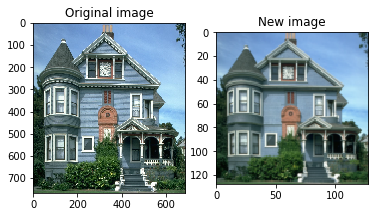

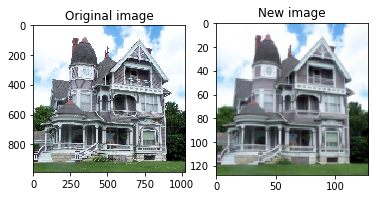

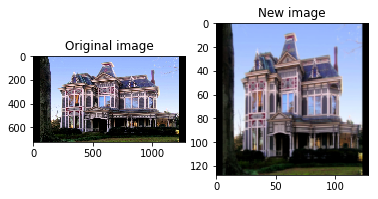

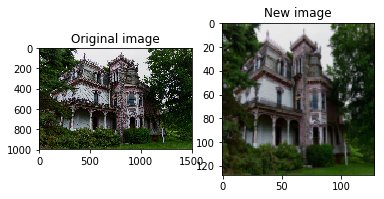

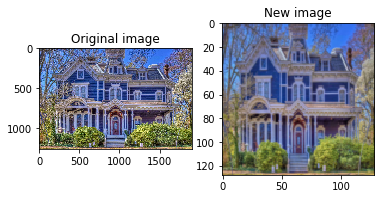

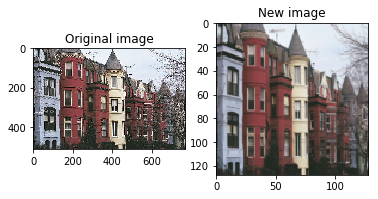

In [8]:
resize_directory(victorian_dir, victorian_output_dir, size=(128, 128))

Skipped: 1.front-exterior-of-craftsman-style-home-royalty-free-image-170414060-1542656034.jpg because it is already in ..\data\processed\Craftsman House


Step: 0.  Resized: 1.front-exterior-of-craftsman-style-home-royalty-free-image-170414060-1542656034.jpg.  Old size: 3433x5120.  New size: 128x128.


Skipped: 10.81214-b600.jpg because it is already in ..\data\processed\Craftsman House
Step: 1.  Resized: 10.81214-b600.jpg.  Old size: 749x970.  New size: 128x128.
Skipped: 11.500007vv_2_1487865056.jpg because it is already in ..\data\processed\Craftsman House


Step: 2.  Resized: 11.500007vv_2_1487865056.jpg.  Old size: 811x1200.  New size: 128x128.
Skipped: 12.Craftsman-cottage-yellow-door-brick-columns.jpg because it is already in ..\data\processed\Craftsman House


Step: 3.  Resized: 12.Craftsman-cottage-yellow-door-brick-columns.jpg.  Old size: 800x1200.  New size: 128x128.
Skipped: 13.il_570xN.1870282096_ob62.jpg because it is already in ..\data\processed\Craftsman House
Step: 4.  Resized: 13.il_570xN.1870282096_ob62.jpg.  Old size: 570x570.  New size: 128x128.
Skipped: 14.1400977224608.jpeg because it is already in ..\data\processed\Craftsman House


Step: 5.  Resized: 14.1400977224608.jpeg.  Old size: 960x1280.  New size: 128x128.
Skipped: 15.w800x533.jpg because it is already in ..\data\processed\Craftsman House
Step: 6.  Resized: 15.w800x533.jpg.  Old size: 533x800.  New size: 128x128.
Skipped: 16.6d2f6f9f4eddedb6b110a78855958632.jpg because it is already in ..\data\processed\Craftsman House


Step: 7.  Resized: 16.6d2f6f9f4eddedb6b110a78855958632.jpg.  Old size: 800x1200.  New size: 128x128.
Skipped: 17.76935-b600.jpg because it is already in ..\data\processed\Craftsman House
Step: 8.  Resized: 17.76935-b600.jpg.  Old size: 650x1200.  New size: 128x128.
Skipped: 18.Neighborhood-craftsman-full-porch-brick-walk.jpg because it is already in ..\data\processed\Craftsman House


Step: 9.  Resized: 18.Neighborhood-craftsman-full-porch-brick-walk.jpg.  Old size: 960x1280.  New size: 128x128.
Skipped: 19.w1024.jpg because it is already in ..\data\processed\Craftsman House
Step: 10.  Resized: 19.w1024.jpg.  Old size: 676x1024.  New size: 128x128.
Skipped: 2.colonialrev.jpg because it is already in ..\data\processed\Craftsman House


Step: 11.  Resized: 2.colonialrev.jpg.  Old size: 906x1200.  New size: 128x128.
Skipped: 20.6102-V1_6.jpg because it is already in ..\data\processed\Craftsman House
Step: 12.  Resized: 20.6102-V1_6.jpg.  Old size: 600x845.  New size: 128x128.
Skipped: 21.perfect-craftsman-style-house-1024x683.jpg because it is already in ..\data\processed\Craftsman House


Step: 13.  Resized: 21.perfect-craftsman-style-house-1024x683.jpg.  Old size: 683x1024.  New size: 128x128.
Skipped: 22.2017-craftsman-header.jpg because it is already in ..\data\processed\Craftsman House
Step: 14.  Resized: 22.2017-craftsman-header.jpg.  Old size: 550x800.  New size: 128x128.
Skipped: 23.032D-0837-front-main-8.jpg because it is already in ..\data\processed\Craftsman House


Step: 15.  Resized: 23.032D-0837-front-main-8.jpg.  Old size: 533x800.  New size: 128x128.
Skipped: 24.Craftsmanhouse.jpg because it is already in ..\data\processed\Craftsman House


Step: 16.  Resized: 24.Craftsmanhouse.jpg.  Old size: 804x1200.  New size: 128x128.
Step: 17.  Resized: 26.craftsman-houses-oxford-ga-118.jpg.  Old size: 320x480.  New size: 128x128.
Step: 18.  Resized: 27.MAIN-IMAGE-Hollybrook-2_1400x.jpg.  Old size: 555x1025.  New size: 128x128.


Step: 19.  Resized: 28.29637-aspen-redo-art.jpg.  Old size: 1080x1920.  New size: 128x128.
Step: 20.  Resized: 29.ffac7c54d5d570902692f18e82a82742.jpg.  Old size: 500x750.  New size: 128x128.


Step: 21.  Resized: 3.Stock-CraftsmanStyleHome-AdobeStock_119145213-copy-compressor.jpeg.  Old size: 800x1200.  New size: 128x128.
Step: 22.  Resized: 30.50-249e.jpg.  Old size: 360x600.  New size: 128x128.


Step: 23.  Resized: 31.craftsman-exterior.jpg.  Old size: 674x1043.  New size: 128x128.
Step: 24.  Resized: 32.home-design.jpg.  Old size: 426x640.  New size: 128x128.
Step: 25.  Resized: 33.46867593-690a-4a6b-a482-c6d76e5a5642.f6.jpg.  Old size: 266x399.  New size: 128x128.
Step: 26.  Resized: 34.new_craftsman_home.jpg.  Old size: 379x714.  New size: 128x128.


Step: 27.  Resized: 35.ZVpHi4IKTF6zYcfnXpk3_full_35ea4a18-38a5-46cb-aef7-35efce0192cc.jpg.  Old size: 960x1440.  New size: 128x128.
Step: 28.  Resized: 36.83074-b600.jpg.  Old size: 525x970.  New size: 128x128.


Step: 29.  Resized: 37.craftsman-home-9-1557854461.jpg.  Old size: 1414x2121.  New size: 128x128.
Step: 30.  Resized: 38.modern-craftsman-house-plans-.jpg.  Old size: 428x644.  New size: 128x128.
Step: 31.  Resized: 39.071D-0127-front-main-8.jpg.  Old size: 600x800.  New size: 128x128.


Step: 32.  Resized: 4.05cc7409f3b7442c8a20ece084ae3bb4.jpg.  Old size: 500x771.  New size: 128x128.


Step: 33.  Resized: 40.710105BTZ_1_1545341710.jpg.  Old size: 801x1200.  New size: 128x128.
Step: 34.  Resized: 41.Plan1611105MainImage_25_2_2019_3_891_593.jpg.  Old size: 593x891.  New size: 128x128.


Step: 35.  Resized: 42.1-peek_exteriorfront01_gn.jpg.  Old size: 899x1200.  New size: 128x128.
Step: 36.  Resized: 43.03ed6dd1a9489abe7ccd3d93e7faf82f.jpg.  Old size: 500x771.  New size: 128x128.


Step: 37.  Resized: 44.23111-front-rendering_1680x800_branded.jpg.  Old size: 800x1680.  New size: 128x128.
Step: 38.  Resized: 45.Plan1631055MainImage_15_10_2018_12_891_593.jpg.  Old size: 593x891.  New size: 128x128.
Step: 39.  Resized: 46.Sister-Lot-73-4-640x480.jpg.  Old size: 480x640.  New size: 128x128.


Step: 40.  Resized: 47.large_Venice_1.jpg.  Old size: 720x1280.  New size: 128x128.


Step: 41.  Resized: 48.Craftsman-exterior-siding-porch-landscaping.jpg.  Old size: 1708x2560.  New size: 128x128.
Step: 42.  Resized: 49.seattle-craftsman-1.jpg.  Old size: 444x400.  New size: 128x128.


Step: 43.  Resized: 5.500063VV_01_1556635118.jpg.  Old size: 800x1200.  New size: 128x128.
Step: 44.  Resized: 50.Resized_Main_Image.jpg.  Old size: 325x600.  New size: 128x128.


Step: 45.  Resized: 51.41318500715_6b97365444_b.jpg.  Old size: 626x1023.  New size: 128x128.
Step: 46.  Resized: 52.4261_1_l_kershaw_house_plan_elevation.jpg.  Old size: 532x800.  New size: 128x128.
Step: 47.  Resized: 53.planimg_1323968491-360x206.jpg.  Old size: 206x360.  New size: 128x128.


Step: 48.  Resized: 54.maxresdefault.jpg.  Old size: 720x1280.  New size: 128x128.
Step: 49.  Resized: 55.craftsman-home-exterior.jpg.  Old size: 428x644.  New size: 128x128.


Step: 50.  Resized: 56.2_portland_craftsman.jpg.  Old size: 800x1200.  New size: 128x128.


Step: 51.  Resized: 57.ourcraftsmancottage_66294029_1423038461183638_330348315192151021_n-ad4e8c446e2b4885a0cffa2cbd7b411d.jpg.  Old size: 960x960.  New size: 128x128.
Step: 52.  Resized: 58.GrayBungalow-7.jpg.  Old size: 639x960.  New size: 128x128.


Step: 53.  Resized: 59.D6KKHJK3L5AVHLO4ZBV74S4WZ4.jpg.  Old size: 932x1400.  New size: 128x128.
Step: 54.  Resized: 6.R2320A2F-0-FRONT.jpg.  Old size: 600x818.  New size: 128x128.


OSError: JPEG does not support alpha channel.

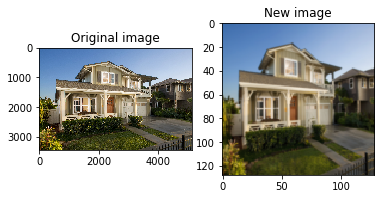

In [9]:
resize_directory(craftsman_dir, craftsman_output_dir, size=(128, 128))